# Дипломная работа:
## Построение скоринг модели для клиентов банка, которая предсказывает вероятность дефолта клиента исходя из анкетных данных, портфельных данных банка, кредитной истории клиента в кредитном бюро и соц.отчислениях из центра выплаты пенсий

### Импортируем библиотеки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import os
from tqdm import tqdm
import sys
import random

from bs4 import BeautifulSoup
import requests 
import csv

from threading import Thread
import queue
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt

# plotly standard imports
import plotly.graph_objs as go

# Options for pandas
pd.options.display.max_columns = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot

import h2o
from h2o.automl import H2OAutoML

import os
import time
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

### Используемые функции для обработки и визуализации

In [2]:
def VizCounterBar(df, column, title, max_values=0):
    """
    Визуализация количества значений в dataframe
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения/ 0 - все
    """
    
    if max_values >0:
        col_values = df[column].value_counts().nlargest(max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12,12)
    plt.figure 
       
    ax = col_values.plot(kind='barh', title = title)
    ax.set_facecolor('lightgrey')
    ax.set_xlim(0, col_values.max()*1.15)
    
    for i, v in enumerate(col_values):
        plt.text(v, i, " "+str(v), va='center')
    
    plt.show()
    
def ShowPlotsLog(column):
    """
    Визуализация распределения значений столбца в dataframe после логарифмирования
    column - столбец в dataframe
    """
        
    df[column]=np.log(df[column]+1)
    df[column].hist(figsize=(10,5))

def Log(column):
    """
     логарифмированиt данных
    column - столбец в dataframe
    """
        
    df[column]=np.log(df[column]+1)   
    
    
def ShowBoxPlots(column):
    """
    Boxplot относительно целевой переменной в dataframe
    column - столбец в dataframe
    x - целевая переменная 
    """
    fig,ax=plt.subplots(figsize=(10,4))
    sns.boxplot(y=column,x='Default', data=df)
    plt.title(column)
    plt.show()
    
def Outliers(column):
    """
    Определение квартилей и границ выбросов для признаков в dataframe
    column - столбец в dataframe
    """
    
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    print (column)
    k = 0
    for i in df[column]:
        if i <= low or i >= up:
            k+= 1
    if k > 0:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR),"Границы выбросов: [{}, {}],".format(low,up), 'Количество выбросов - ', k)
    else:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low,up), 'Выбросов нет') 

def OutliersUniform(column):
    """
    Определяем выбросы и задаем значение внутри границ выбросов в столбце dataframe
    column - столбец в dataframe
    """
  
    x=0
    perc25, perc75 = np.percentile(df[column], [25, 75])
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    if type(column[0])==int:
        x=random.randint(low,up)
    else:
        x=random.uniform(low,up)
    for i in range(len(df)):
        if df[column][i] < low or  df[column][i] > up:
            df[column][i] = x      
            
            
def ColInfo(column):
    """
    общая информация по определенному признаку, вроде кол-во пустых значений, мин и макс и тд
    column - столбец в dataframe
    """
    
    print('Количество пропусков: {},'.format(column.isnull().sum()))
    print('{},'.format(column.describe()))
    print('Распределение:\n{},'.format(column.value_counts()))
    column.hist(figsize=(7,5)) 
    
def ShowValuesOnBars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() 
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va ='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def CityExtract(column):
    """
    перезаписываем столбец с указанием основных городов, а остальное относим в others
    """
    
    df[column].fillna(0, inplace=True)
    df.loc[:,column] = df.loc[:,column].map(cities_map)
    df[column].fillna(23, inplace=True)
    
def DateOfBirthCorr(row):
    """
    конвертируем дату рождения в формат даты и времени и заполняем пустые значения данными из ИИН
    """
    birthdate = row['dateofbirth']
    if birthdate != 0:
        row['dateofbirth'] = datetime.strptime(str(birthdate), '%Y-%m-%d %H:%M:%S')
    else:
        iin = str(row['iin_x'])
        if iin[6] in ['3', '4']:
            row['dateofbirth'] = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
        else:
            row['dateofbirth'] = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    return row           


### Cловари

In [3]:
## выделяем основные города с 1-22, 0 - нет значений, 23 - прочие села/поселки/мелкие города
cities_map = {0:0,'г.Алматы': 1, 'г.Актау': 2, 'г.Талдыкорган': 3, 'г.Нур-Султан': 4, 'г.Астана': 4, \
          'г.Атырау': 5, 'г.Караганда': 6, 'г.Семей': 7, 'г.Уральск': 8, 'г.Актобе': 9, \
          'г.Усть-Каменогорск': 10, 'г.Костанай': 11, 'г.Павлодар': 12, 'г.Тараз': 13, \
          'г.Кызылорда': 14, 'г.Экибастуз': 15, 'г.Петропавловск': 16, 'г.Кокшетау': 17, \
          'г.Шымкент': 18, 'г.Жезказган': 19, 'г.Темиртау': 20, 'г.Туркестан': 21, 'г.Каскелен': 22}

### Парсим информацию из кредитного бюро и на этом же этапе создаем фичи

In [4]:
def pkb_parse(request):
    """
    парсим все необходимые данные из кредитного бюро
    """
    mysql_statement = f"""select  * from soap_log where requestid like '{request}%' and SERVICE_NAME = 'PKB'"""
    a = pd.read_sql_query(mysql_statement, connection)
    empty_list = [0 for i in range(94)]
    empty_list[0] = request
    try:
        raz = next(iter(a.loc[a.ID == a.ID.max(), 'RESPONSE'])).read()
        dt64 = a.CHANGEDATE.values[0]
        ts = (dt64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
       # проверяем на ошибки при выгрузке отчета из кредитного бюро
        time_calc = datetime.utcfromtimestamp(ts)
    except:
        error_text = 'No Soap'
        
        empty_list[-1] = error_text
        return empty_list
    response_pkb1 = ElementTree.fromstring(raz)
    try:
        error_text = response_pkb1.find('.//Errmessage').text
    except:
        error_text = 'OK'
    if response_pkb1.find('.//code').text.split('-')[1] != '0000':
        error_text = response_pkb1.find('.//code', ns).text
        final = error_text
        return final
    elif error_text != 'OK':
        empty_list[-1] = error_text
        return empty_list
    else:
        try:
            pkb_client_dict = pkb_client_data(response_pkb1, time_calc)
        except:
            empty_list[-1] = error_text
            return empty_list
    error_text = ''
    Pkb_contract, Pkb_payment = pkb_contract_payment (response_pkb1, time_calc)
    final_data = pkb_features (Pkb_contract, Pkb_payment, ts, pkb_client_dict)
    final_data = final_data[0] + list(pkb_client_dict.values())
    final_data.append(error_text)

    return final_data
# всего создается 3 таблицы: информация по анкете клиента, информация по всем договорам, 
# вновь созданные признаки основанные на данных из кредитного бюро

def pkb_client_data (response_pkb1, time_calc):
    """
    создаем таблицу с данными по клиенту из кредитного бюро
    """
    pkb_client_dict = {}
    
    # негативный статус клиента
    pkb_client_dict['NegativeStatusOfClient']=response_pkb1.find('.//NegativeStatusOfClient/NegativeStatusOfClient').get('value')
    
    # количество запросов из кредитного бюро за периоды
    pkb_client_dict['Days7'] = len(response_pkb1.findall('.//DetailsQueries7days/query'))
    for i in ['Days30', 'Days90', 'Days120','Days180', 'Days360']:
        pkb_client_dict[i] = int(response_pkb1.find('.//' + i).get('value'))
    
    # поиск негативного статуса в публичных государственных источниках
    for i in ['QamqorList' , 'KgdWanted', 'QamqorAlimony', 'RNUGosZakup', 'FalseBusi',\
              'TerrorList', 'Areears', 'Bankruptcy','L150o10']:
        pkb_client_dict[i] = response_pkb1.find('.//PublicSources/' + i + '/Status').get('id')
        
    # поиск свежего адреса проживания
    for i in (response_pkb1.findall('.//Address')):
        addresstype = i.find('.//AddressType').get('value')
        address_city = []
        if addresstype != "Место рождения":
            address_city.append(i.find('.//City').get('value'))
    pkb_client_dict['Last_city'] = address_city[-1]
        
         
    # анкетные данные
    for i in ['IIN', 'DateOfBirth', 'Gender', 'City', 'Region', 'NumberOfDependents', \
              'Education', 'MatrialStatus', 'EmployeesSalary', 'ZipCode','CellularPhone',\
              'SubjectsEmployment','Citizenship','EconomicActivityGroup','CityOfBirth']:
        pkb_client_dict[i] = response_pkb1.find('.//' + i).get('value').strip()
    pkb_client_dict['DateOfBirth'] = datetime.strptime(pkb_client_dict['DateOfBirth'], '%d.%m.%Y')
    pkb_client_dict['Age'] = relativedelta(time_calc, pkb_client_dict['DateOfBirth']).years
    
    # Создание даты рождения из ИИН-а
    iin = pkb_client_dict['IIN']
    if iin[6] in ['3', '4']:
        birthdate = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    else:
        birthdate = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    
    # Пол из ИИН и максимальный возраст выхода на пенсию, для мужчин и женщин свой
    if iin[6] in ['3', '6']:
        max_age = 63*12
    else:
        max_age = 60*12
    Age = relativedelta(time_calc, birthdate)
    
    # расчет максимального срока кредита
    pkb_client_dict['max_term'] = max_age - (Age.years * 12 + Age.months + 1)
    return pkb_client_dict


def pkb_contract_payment (response_pkb1, time_calc):
    """
    создаем таблицу с данными по контрактам и платежам по контрактам из кредитного бюро
    """
    columns_value = ["CodeOfContract", "AgreementNumber", "CurrencyCode",  'DateOfApplication',\
               'DateOfCreditStart',  'DateOfCreditEnd', 'DateOfRealRepayment', 'DateAgreementGuarantee',\
               'GuaranteeEvent', 'ClassificationOfContract', 'LastUpdate', 'TotalAmount', 'Amount', 'ResidualAmount', \
                'CreditLimit','NumberOfOutstandingInstalments', 'NumberOfInstalments', 'OutstandingAmount', \
                 'NumberOfOverdueInstalments', 'OverdueAmount', 'MonthlyInstalmentAmount', 'SubjectRole', \
                 'GracePrincipal','GracePay', 'ContractThirdParty', 'ProlongationCount', 'DateOfInserted', \
                 'NumberOfOverdueInstalmentsMax', 'NumberOfOverdueInstalmentsMaxAmount', 'OverdueAmountMax',\
                'SpecialRelationship', 'NominalRate', 'TypeOfGuarantee', 'ValueOfGuarantee', 'TypeOfValueOfGuarantee',\
                'AmountProvisions', 'InterestRate','OverdueAmountMaxDate', 'OverdueAmountMaxCount', 'NumberOfOverdueInstalmentsMaxDate']
    columns_id = ['TypeOfFounding', 'ContractStatus', 'PeriodicityOfPayments', 'MethodOfPayments', \
                  'FinancialInstitution','PurposeOfCredit']

    pkb_contracts = []

    df_cols_payment = ['PAYMENTDATE', 'PAYMENTOVERDUE', 'PAYMENTVALUE', 'PAYMENTFINE', 'PAYMENTPENALTY', 'CHANGEDATE', 'PKB_ID']
    rows_payment= []
    number = 0
    for existence in ['ExistingContracts' , 'TerminatedContracts']:
        for  contract in (response_pkb1.findall('.//' + existence + '/Contract')):
            contract_info = []
            contract_info.append(existence)
            contract_info.append(number)
            for column in columns_value:
                try:
                    contract_info.append(contract.find('.//' + column  ).get('value'))
                except:
                    contract_info.append(np.nan)
            for column in columns_id:
                contract_info.append(contract.find('.//' + column  ).get('id'))
            pkb_contracts.append(contract_info)
            for years in contract.findall('.//Year'):
                year=years.get('title')
                for payments in years.findall('Payment'):
                    PAYMENTDATE=date(int(year), int(payments.get('number')), 1)
                    PAYMENTOVERDUE=payments.get('overdue')
                    PAYMENTVALUE=payments.get('value')
                    PAYMENTFINE=payments.get('fine')
                    PAYMENTPENALTY=payments.get('penalty')
                    CHANGEDATE=datetime.now()

                    if payments.get('title')!="":
                        rows_payment.append([PAYMENTDATE, PAYMENTOVERDUE, PAYMENTVALUE, PAYMENTFINE, PAYMENTPENALTY, CHANGEDATE, number])
            number += 1

    Pkb_contract = pd.DataFrame(pkb_contracts, columns = ['Status', 'PKB_ID'] + columns_value + columns_id) 
    Pkb_payment = pd.DataFrame(rows_payment, columns = df_cols_payment) 
    
    
    # форматирование  Pkb_contract
    
    float_list = ['TotalAmount', 'Amount', 'ResidualAmount', 'CreditLimit', 'NumberOfOutstandingInstalments', \
                'NumberOfInstalments', 'OutstandingAmount','NumberOfOverdueInstalments', 'OverdueAmount', \
                'MonthlyInstalmentAmount', 'NumberOfOverdueInstalmentsMax', \
                'NumberOfOverdueInstalmentsMaxAmount', 'OverdueAmountMax','NominalRate', 'ValueOfGuarantee', \
                'AmountProvisions', 'InterestRate', 'OverdueAmountMaxCount']

    for i in float_list:
        Pkb_contract[i] = pd.to_numeric(Pkb_contract[i].str.replace(r"[a-zA-Z]",'') \
                                      .str.replace(',', '.').str.replace(' ', ''), errors = 'raise').astype(float)
    date_list = ['DateOfApplication', 'DateOfCreditStart', 'DateOfCreditEnd', 'DateOfRealRepayment', \
                 'DateAgreementGuarantee', 'LastUpdate', 'DateOfInserted','OverdueAmountMaxDate',\
                 'NumberOfOverdueInstalmentsMaxDate']
    for i in date_list:
        Pkb_contract[i] = Pkb_contract[i].str.replace('-', '')
        Pkb_contract[i] = pd.to_datetime(Pkb_contract[i], errors='coerce')

    for i in date_list:
        Pkb_contract.loc[Pkb_contract[i].isnull(), i] = time_calc
    
    #  Форматирование Pkb_payment
    for i in ['PAYMENTOVERDUE', 'PAYMENTVALUE', 'PAYMENTFINE', 'PAYMENTPENALTY']:
        Pkb_payment[i] = pd.to_numeric(Pkb_payment[i].str.replace(r"[a-zA-Z]",'').str.replace(',', '.') \
                                       .str.replace(' ', '').str.replace('-', '0'), errors='raise').astype(float)
    try:
        Pkb_payment['PAYMENTDATE'] = pd.to_datetime(Pkb_payment['PAYMENTDATE'])
    except:
        pass
    
    try:
            Pkb_payment['PAYMENTDATE'] = pd.to_datetime(Pkb_payment['PAYMENTDATE'])
    except:
        pass

    return Pkb_contract, Pkb_payment



def pkb_features (Pkb_contract, Pkb_payment, ts, pkb_client_dict):
    """
    создаем таблицу с созданными ранее признаками и генерим новые фичи, все фичи создается на уровне парсинга
    """
    final = []
    time1 = datetime.now()
    time_calc=datetime.utcfromtimestamp(ts)
    

    bvu_list = ['111', '112', '113', '114', '116', '117', '118', '119', '120', '121', '122', '123', '124', \
                '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '136', '137', '138', \
          '139', '140', '141', '142', '143', '144', '151', '152', '153', '154', '155', '156', '157', \
          '158', '159', '160', '161', '162', '163', '164', '165', '167', '168', '169', '170', '171', \
          '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', \
          '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', \
          '198', '199', '200', '201', '202', '203', '204', '205', '207', '208', '209', '210', '211', '213']
    bvu_name='АО КАЗКОММЕРЦБАНК|АКЦИОНЕРНОЕ ОБЩЕСТВО БТА БАНК|АКЦИОНЕРНОЕ ОБЩЕСТВО НАРОДНЫЙ БАНК КАЗАХСТАНА|АО ЦЕСНАБАНК|АО БАНК ЦЕНТР КРЕДИТ|АО БАНКПОЗИТИВ|АО ТЕМІРБАНК|АО СЕНИМ-БАНК|АО АТФБАНК|АО ЖИЛСТРОЙСБЕРБАНК КАЗАХСТАНА|АО КАЗИНВЕСТБАНК|АО СИТИБАНК КАЗАХСТАН|АО БАНК BANK RBK|ДБ АО HSBC БАНК КАЗАХСТАНА|АО KASPI BANK|АО ДБ RBS (KAZAKHSTAN)|АО ДБ ТАИБ КАЗАХСКИЙ БАНК|АО ДБ НАЦ.БАНК ПАКИСТАНА В КАЗАХСТАНЕ|АО ТП БАНК КИТАЯ В Г.АЛМАТЫ|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЛМАТЫ ФИНАНС|ТОО ПРОСТОКРЕДИТ|АО ХОУМ КРЕДИТ БАНК|АО ДБ АЛЬФА-БАНК|АО ДБ БАНК КИТАЯ В КАЗАХСТАНЕ|ТОО КТ ЭКСПРЕСС|АО ЭКСИМБАНК КАЗАХСТАН|ТОО РАЙФФАЙЗЕН ЛИЗИНГ КАЗАХСТАН|АО ЕВРАЗИЙСКИЙ БАНК|АО ВАЛЮТ-ТРАНЗИТ БАНК|АО «ДБ «PUNJAB NATIONAL BANK-КАЗАХСТАН».|АО DELTA BANK|АО ДБ КЗИ БАНК|АО НУРБАНК|АСТАНА-ФИНАНС АО|АО ASIACREDIT BANK|119900/ АКЦИОНЕРНОЕ ОБЩЕСТВО КАЗАГРОФИНАНС|ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ БТА ИПОТЕКА АО|ФОНД РАЗВИТИЯ ПРЕДПРИНИМ-ВА ДАМУ|SBERBANK ROSSII ALMATY KAZAKHSTAN|ТОО МКО ТАТ СЕНИМ|АО БРК-ЛИЗИНГ ДОЧЕРНЯЯ ОРГАНИЗАЦИЯ АО БАНК РАЗВИТИЯ КАЗАХСТАНА|АО ИО ЭЛИТСТРОЙ ФИНАНС|ТОО МКО НАРОДНЫЙ КРЕДИТ|АО ФОНД ФИН.ПОДДЕРЖКИ С/Х|АЛЬЯНС БАНК|АО ХОУМ КРЕДИТ КАЗАХСТАН|ТОО МКО KAZBUSINESS ДЕМЕУ|АО ИО БИРЮЗА|МИКРОКРЕДИТНАЯ ОРГАН. АСТАНА-ФИНАНС|АО ИО КАЗИПОТЕКА|HOMEBROKER АО|АО ИО КУРЫЛЫС ИПОТЕКА|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИ|АО ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ АСТАНА-ФИНАНС|АО ЗАМАН-БАНК|АО ЛИЗИНГОВАЯ КОМПАНИЯ АСТАНА-ФИНА..|АО АГРАРНАЯ КРЕДИТНАЯ КОРПОРАЦИЯ|АО КОМПАНИЯ ПО РЕАБИЛИТАЦИИ И УПРАВЛЕНИЮ АКТИВАМИ|АО АЛЬТЕРНАТИВНЫЕ ФИНАНСЫ|АО ИО ДАМУ|АО МЕТРОКОМБАНК|ТОО КТ «МАСТЕР- КРЕДИТ|АО ПРОДОВОЛЬСТВЕННАЯ КОНТРАКТНАЯ КОРПОРАЦИЯ|АО НК КАЗМУНАЙГАЗ|АО ИО ТАТ ИПОТЕКА|ТОО МКО СЕНТРАС КРЕДИТ|АО ФНБ САМРУК-КАЗЫНА|АО БАНК АСТАНА-ФИНАНС|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ KAZMICROFINANCE|АО АЛМАТИНСКАЯ РЕГИОНАЛЬНАЯ ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ|АО ИО КИК|АО ШИНХАН БАНК КАЗАХСТАН|АО ФИНАНСОВАЯ КОМПАНИЯ REAL-INVEST.KZ|ЛИЗИНГ ГРУПП АО|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЛТЫН ОРДА|ДО АО БАНК ВТБ (КАЗАХСТАН)|АО «БАНК РАЗВИТИЯ КАЗАХСТАНА»|ТОО МКО ПРОСТО КРЕДИТ|АО БАНК KASSA NOVA|АО ИСЛАМСКИЙ БАНК AL HILAL|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЗИАТСКИЙ КРЕДИТНЫЙ ФОНД|ТОО «РЕГИОНАЛЬНЫЙ ИНВЕСТИЦИОННЫЙ ЦЕНТР «МАКСИМУМ»|АО КРЕДИТ АЛТЫН БАНК|ТОО МКО ГАРАНТКАЗФИНАНС|ТОО МКО АКТОБЕ АУЫЛ МИКРОКРЕДИТ|ТОО ТЕХНОЛИЗИНГ|ТОО МКО 1КРЕДИТ|ТОО МКО МИКРОКРЕДИТНЫЙ ДОМ|ТОО МКО АРНУР КРЕДИТ|ТОО МКО  CREDIT SYSTEMS|МКО ЧЕЛСИ ТОО|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ SERTA'


    Pkb_contract['term'] = Pkb_contract.apply(lambda x: relativedelta(x['DateOfCreditEnd'], x['DateOfCreditStart'])\
                                              .years * 12 + relativedelta(x['DateOfCreditEnd'], x['DateOfCreditStart'])\
                                              .months, axis = 1).astype(float)
    Pkb_contract.loc[Pkb_contract['term'] < 6, 'term'] = 6
    Pkb_contract['MonthlyInstalmentAmount_alt_kl'] = Pkb_contract['CreditLimit'] / 10
    Pkb_contract['MonthlyInstalmentAmount_alt'] = Pkb_contract['TotalAmount'] / Pkb_contract['term']
    Pkb_contract['MonthlyInstalmentAmount_Max'] = Pkb_contract[["MonthlyInstalmentAmount", "MonthlyInstalmentAmount_alt", \
                                                                "MonthlyInstalmentAmount_alt_kl"]].max(axis = 1)
    

    PAYMENTOVERDUE_table = pd.merge(Pkb_payment, Pkb_contract[['Status', 'PKB_ID', 'TypeOfFounding', \
                                                               'MonthlyInstalmentAmount_Max','NumberOfOverdueInstalmentsMaxDate']], how = 'left', on = ['PKB_ID'])

    # объединение платежей по дате. as_index=False не дает им создать дополнительное поле, с объединенными ячейками
    aggregation_functions = { 'MonthlyInstalmentAmount_Max':'sum'}
    payment_sum=PAYMENTOVERDUE_table[PAYMENTOVERDUE_table['Status'] == 'TerminatedContracts'].groupby(['PAYMENTDATE'], as_index = False)\
    .aggregate(aggregation_functions)    
    payment_sum_all = PAYMENTOVERDUE_table.groupby(['PAYMENTDATE'], as_index = False).aggregate(aggregation_functions)    

    # более 10 000тг, более 10 дней за 3 мес по текущим кредитам
    Prosr_3 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY']  > 10000) & \
                                     (PAYMENTOVERDUE_table['Status'] == 'ExistingContracts') & \
                                     (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 10) & \
                                     (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +3)))].index)

    # более 10 000тг, более 30 дней за 12 мес по всем кредитам
    Prosr_12 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY'] > 10000)& \
                                        (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 30)& \
                                        (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +12)))].index)

    # более 10 000тг, более 90 дней за 36 мес по всем кредитам
    Prosr_36 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY'] > 10000)& \
                                      (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 90)& \
                                      (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +36)))].index)
    Payments_2_years = len(Pkb_payment['PAYMENTDATE'][Pkb_payment['PAYMENTDATE'] > (time_calc - relativedelta(months = +24))].index)
    

    # плохие формы расчета (через переуступку, через страховые выплаты, выстреливание гарантии и тд)
    Bad_MethodOfPayments = len(Pkb_contract[Pkb_contract['MethodOfPayments']\
                                            .isin(['5','7','8','9','10','11','13', '14'])].index)

    # уступка-переуступка
    ustupka = len(Pkb_contract[((~Pkb_contract['ContractThirdParty'].str.contains(bvu_name, case = False, regex = True, na = False))\
                                | (~Pkb_contract['FinancialInstitution'].isin(bvu_list))) \
                               & (Pkb_contract['ContractStatus'].isin(['2']))].index)
    
    five_year = time_calc - relativedelta(months = +60)
    # Негативные статусы по текущим займам
    current_neg_status = len(Pkb_contract[((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                 '21', '22', '23', '24' ,'25'])) \
                                           | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13']))) \
                                          & (Pkb_contract['Status'] == 'ExistingContracts')].index)

    # Негативные статусы по закрытым займам до 60 мес
    terminated_neg_status = len(Pkb_contract[((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                    '21', '22', '23', '24' ,'25'])) \
                                              | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13']))) \
                                             & (Pkb_contract['Status'] == 'TerminatedContracts') \
                                             & (Pkb_contract['DateOfCreditEnd'] > five_year)].index)

    # если есть просрочка более 5-и лет, то проверка на закрытый кредит после с просрочкой менее 30 дней.
    if pd.isnull(Pkb_contract['DateOfCreditEnd'][((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                        '21', '22', '23', '24' ,'25']))\
                                                  | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                 & (Pkb_contract['Status']=='TerminatedContracts')\
                                                 & (Pkb_contract['DateOfCreditEnd'] < five_year)].max()):
        terminated_neg_status_1 = 0
    else:
        maxenddate = Pkb_contract['DateOfCreditEnd'][((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20',\
                                                                                            '21', '22', '23', '24' ,'25']))\
                                                      | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                     & (Pkb_contract['Status'] == 'TerminatedContracts')\
                                                     & (Pkb_contract['DateOfCreditEnd'] < five_year)].max()
        terminated_neg_status_1 = len(Pkb_contract[((~Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                           '21', '22', '23', '24' ,'25']))\
                                                    | (~Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                   & (Pkb_contract['Status'] == 'TerminatedContracts')\
                                                   & (Pkb_contract['DateOfCreditStart'] > maxenddate) \
                                                   & (Pkb_contract['NumberOfOverdueInstalmentsMax'] < 30)].index)

    
     # негативный статус клиента
    if pkb_client_dict['NegativeStatusOfClient'] in [None, 'Клиент не имеет негативной информации']:
        NegativeStatusOfClient_fin = 0
    else:
        NegativeStatusOfClient_fin = 1

    # количесто дней с самой первой даты кредитования
    OldestDayToScore = (time_calc-min(Pkb_contract['DateOfCreditStart'])).days
    
    # количесто дней с самой свежей даты кредитования
    NewestDayToScore = (time_calc-max(Pkb_contract['DateOfCreditStart'])).days   
    
    # среднее количесто дней с начала кредитования
    DayfromDateOFCreditStart_mean = (time_calc - Pkb_contract['DateOfCreditStart']).mean().days
    
    # среднее количесто дней с последней задолженности
    DayfromNOfOverdueInstMaxDate_mean_0 =  (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']\
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 0].mean()).days                                                             
    DayfromNOfOverdueInstMaxDate_mean_10 = (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']\
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 10].mean()).days 
    DayfromNOfOverdueInstMaxDate_mean_30 = (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 30].mean()).days 
    
    # сумма максимальных просрочек                                                                              
    OverdueAmountMax_SUM = Pkb_contract['OverdueAmountMax'].sum() 
                                                                                  
    # сумма дней прошедших от максимальной задолженности
    DayfromOverdueAmountMaxDate_sum = (time_calc - Pkb_contract['OverdueAmountMaxDate']).sum().days                                                                            
    
    # среднее количесто дней прошедших от максимальной задолженности
    DayfromOverdueAmountMaxDate_mean = (time_calc -Pkb_contract['OverdueAmountMaxDate']\
                                        [Pkb_contract['OverdueAmountMaxCount'] != 0]).mean().days
                                                                          
                                                                                  
    # сумма задержек выплаты
    NumberOfOverdueInstalmentsMaxAmount_SUM = Pkb_contract['NumberOfOverdueInstalmentsMaxAmount'].sum()
                                                                                  
    # среднее значение остатков
    ResidualAmount_mean = Pkb_contract['ResidualAmount'].mean()
                                                                                  
    # количество текущих займов
    CNT_CUR = len(Pkb_contract[(Pkb_contract['Status'] == 'ExistingContracts') & (Pkb_contract['TypeOfFounding'] == '2')].index)
    
    # количество исполненных займов
    CNT_HST = len(Pkb_contract[(Pkb_contract['Status'] == 'TerminatedContracts') & (Pkb_contract['TypeOfFounding'] == '2')].index)

    # сумма текущих займов
    SUMNE_TOTAL_CUR = next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма закрытых займов
    SUMNE_TOTAL_HST = next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    # сумма покрытия залогами по текущим договора
    SUMCOVER_TOTAL_CUR = next(iter(Pkb_contract[['ValueOfGuarantee']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма покрытия залогами по закрытым договора
    SUMCOVER_TOTAL_HST = next(iter(Pkb_contract[['ValueOfGuarantee']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    # сумма начисленных провизий по текущим договора
    PROVISIONS_TOTAL_CUR = next(iter(Pkb_contract[['AmountProvisions']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма начисленных провизий по закрытым договора
    PROVISIONS_TOTAL_HST = next(iter(Pkb_contract[['AmountProvisions']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    
    # признак собран согласно требований регулятора 
    Nac_bank_8 = Pkb_contract['TotalAmount'][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].max()
    
    # SUMNE_TOTAL_CUR_AVER - средняя сумма текущих займов (Если займов нет, то 0
    # SUMNE_TOTAL_HST_AVER - Средняя Сумма закрытых займов (Если займов нет, то 0)
    if CNT_CUR == 0:
        SUMNE_TOTAL_CUR_AVER = 0
        SUMCOVER_TOTAL_CUR_AVER = 0
        repaid_percent_rate_cur = 0
        repaid_cur_sum = 0
        Current_payment = 0
    else:
        SUMNE_TOTAL_CUR_AVER = SUMNE_TOTAL_CUR / CNT_CUR
        SUMCOVER_TOTAL_CUR_AVER = SUMCOVER_TOTAL_CUR / CNT_CUR
        repaid_cur_sum = (next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                                 & (Pkb_contract['Status']=='ExistingContracts')].sum()))\
                                   - next(iter(Pkb_contract[['OutstandingAmount']][(Pkb_contract['TypeOfFounding'] == '2')\
                                                                 & (Pkb_contract['Status'] == 'ExistingContracts')].sum())))
        repaid_percent_rate_cur = repaid_cur_sum \
        / next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                        & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
      
        Current_payment = next(iter(Pkb_contract[['MonthlyInstalmentAmount_Max']][(Pkb_contract['Status'] == 'ExistingContracts')].sum()))

    # max_payment_all - максимальный одновременный платеж по всем займам 
    # repaid_count_rate - % закрытого количества кредитов от общего количества
    if CNT_CUR == 0 and CNT_HST == 0:
        repaid_count_rate = 0
        max_payment_all = 0

    else:
        repaid_count_rate = CNT_HST / (CNT_HST + CNT_CUR)
        max_payment_all = payment_sum_all['MonthlyInstalmentAmount_Max'].max()

    # repaid_percent_rate -  % закрытой суммы кредитов от общей суммы
    # repaid_percent_rate_cur - % закрытой суммы кредитов от общей суммы  по действующим 
    if next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum())) == 0:
        repaid_percent_rate = 0
        repaid_sum = 0
    else:
        repaid_sum = next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum())) \
        - next(iter(Pkb_contract[['OutstandingAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum()))
        repaid_percent_rate = repaid_sum / next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum()))


    if CNT_HST == 0:
        SUMNE_TOTAL_HST_AVER = 0
        SUMCOVER_TOTAL_HST_AVER = 0
        # max_payment_closed - максимальный одновременный платеж по закрытым займам                                                                
        max_payment_closed = 0
    else:
        SUMNE_TOTAL_HST_AVER = SUMNE_TOTAL_HST / CNT_HST
        SUMCOVER_TOTAL_HST_AVER = SUMCOVER_TOTAL_HST / CNT_HST
        max_payment_closed = payment_sum['MonthlyInstalmentAmount_Max'].max()

    # признак созданный по требованию регулятора
    Nac_bank_7 = payment_sum['MonthlyInstalmentAmount_Max'][payment_sum['PAYMENTDATE'] > (time_calc - relativedelta(months = +36))].max()


    if SUMNE_TOTAL_HST_AVER == 0:
        # amount_cof - cоотношение средней суммы  текущих займов к закрытым (берет ли клиент больше сумму, чем раньше)                                                                 
        amount_cof = 100
    else:
        amount_cof = SUMNE_TOTAL_CUR_AVER / SUMNE_TOTAL_HST_AVER

    # PROSR_DAY_MAX - максимальная просрочка за все время                                                                    
    PROSR_DAY_MAX = Pkb_payment['PAYMENTVALUE'].max()
                                                                                  
    ## среднее значение максимальных просрочек
    DAYSOVERDUEAMOUNTMAX_mean = Pkb_contract['NumberOfOverdueInstalmentsMax'].mean()                                                                              

    # CNT_PAY - количество всех платежей                                                                    
    CNT_PAY = len(Pkb_payment.index)
                                                                        
    # PROSR_CNT - количество допущенных просрочек                                                                    
    PROSR_CNT = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] > 0].index)
                                                                        
     # PROSR_CNT_10_plus - количество допущенных просрочек более 10 дней                                                                   
    PROSR_CNT_10_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] > 0].index)
                                                                        
    # PROSR_CNT_30_plus - количество допущенных просрочек более 30 дней                                                                    
    PROSR_CNT_30_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] >= 30].index)
                                                                        
     # PROSR_CNT_90_plus - количество допущенных просрочек более 90 дней                                                                    
    PROSR_CNT_90_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] >= 90].index)

    # PROSR_CNT_percent - PROSR_CNT/CNT_PAY                                                                    
    PROSR_CNT_percent = PROSR_CNT / CNT_PAY
                                                                        
    # PROSR_CNT_10_plus_percent - PROSR_CNT_10_plus/CNT_PAY                                                                    
    PROSR_CNT_10_plus_percent = PROSR_CNT_10_plus / CNT_PAY
                                                                        
    # PROSR_CNT_30_plus_percent - PROSR_CNT_30_plus/CNT_PAY                                                                    
    PROSR_CNT_30_plus_percent = PROSR_CNT_30_plus / CNT_PAY
                                                                        
    # PROSR_CNT_90_plus_percent - PROSR_CNT_90_plus/CNT_PAY                                                                    
    PROSR_CNT_90_plus_percent = PROSR_CNT_90_plus / CNT_PAY
                          
    # mko_count - количество кредитов взятых не у БВУ, а в МКО                                                                   
    mko_count = len(Pkb_contract[~Pkb_contract['FinancialInstitution'].isin(bvu_list)])
    try:
        Max_NumberOfInstalments = Pkb_contract['NumberOfInstalments'].max()
        Max_prosr_sum = Pkb_payment['PAYMENTOVERDUE'][Pkb_payment['PAYMENTVALUE'] > 30].max()
    except:
        Max_NumberOfInstalments = 0
        Max_prosr_sum = 0

    #  credit_card_count  - количество кредитных карточек
    credit_card_count = len(Pkb_contract[Pkb_contract['TypeOfFounding'] == '9'])

    final.append([request, time1, NegativeStatusOfClient_fin, Prosr_3, Prosr_12, Prosr_36, \
                  Bad_MethodOfPayments, ustupka, current_neg_status, terminated_neg_status, terminated_neg_status_1, CNT_CUR, \
                  CNT_HST, repaid_count_rate, repaid_cur_sum, repaid_sum, \
                  repaid_percent_rate, repaid_percent_rate_cur, SUMNE_TOTAL_CUR, \
                  SUMNE_TOTAL_HST, SUMNE_TOTAL_CUR_AVER, SUMNE_TOTAL_HST_AVER, max_payment_closed, max_payment_all, amount_cof, \
                  PROSR_DAY_MAX, CNT_PAY, PROSR_CNT, PROSR_CNT_10_plus, PROSR_CNT_30_plus, PROSR_CNT_90_plus, \
                  PROSR_CNT_percent, PROSR_CNT_10_plus_percent, PROSR_CNT_30_plus_percent, PROSR_CNT_90_plus_percent, mko_count, \
                  Max_NumberOfInstalments, credit_card_count, Max_prosr_sum, Payments_2_years, Nac_bank_8, Nac_bank_7, \
                  Current_payment, SUMCOVER_TOTAL_CUR_AVER, SUMCOVER_TOTAL_HST_AVER,  PROVISIONS_TOTAL_CUR, \
                  PROVISIONS_TOTAL_HST, OldestDayToScore, NewestDayToScore, DayfromDateOFCreditStart_mean, \
                  DayfromNOfOverdueInstMaxDate_mean_0, DayfromNOfOverdueInstMaxDate_mean_10, DayfromNOfOverdueInstMaxDate_mean_30, \
                  OverdueAmountMax_SUM, DayfromOverdueAmountMaxDate_sum, DayfromOverdueAmountMaxDate_mean, \
                  NumberOfOverdueInstalmentsMaxAmount_SUM, ResidualAmount_mean, DAYSOVERDUEAMOUNTMAX_mean])
    return final

def gcvp_parse(request):
    empty_list = [0 for i in range(22)]
    empty_list[0] = request
    final = []
    mysql_statement = f"""select  * from soap_log where requestid like '{request}%' and SERVICE_NAME='GCVP'"""
    a=pd.read_sql_query(mysql_statement, connection)
    try:
        raz=next(iter(a.loc[a.ID == a.ID.max(), 'RESPONSE'])).read()
        error_text = 'Ok'
        empty_list[15] = error_text
        #     для даты по историческим заявкам , а не от текущей даты
        dt64 = a.CHANGEDATE.values[0]
        ts = (dt64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
        time_calc=datetime.utcfromtimestamp(ts)
    except:
        error_text = 'No Soap'
        empty_list[15] = error_text
        return empty_list
    root=ElementTree.fromstring(raz)
    ns = {'soapenv':"http://schemas.xmlsoap.org/soap/envelope/"}
    df_cols = ["organizationBin", "organizationName", "PAYMENTDATE", "amount"]
    rows = []
    if root.find('.//code', ns).text.split('-')[1] != '0000':
        error_text = root.find('.//code', ns).text
        empty_list[15] = error_text
        return empty_list
    elif root.find('.//responseCode', ns).text != 'FOUND':
        empty_list[15] = root.find('.//responseCode', ns).text
        return empty_list
    else:
        iin = root.find('.//iin', ns).text
        for actor in root.findall('.//deductions', ns):
            organizationBin = actor.find('organizationBin', ns).text
            organizationName = actor.find('organizationName', ns).text
            PAYMENTDATE = actor.find('date', ns).text.split('T')[0]
#                 PAYMENTDATE = parser.parse(PAYMENTDATE).replace(tzinfo=None)
            amount= actor.find('amount', ns).text
            rows.append({"organizationBin": organizationBin, "organizationName": organizationName, 
                         "PAYMENTDATE": PAYMENTDATE, "amount": amount})


    out_df = pd.DataFrame(rows, columns = df_cols)
    out_df1 = pd.DataFrame(rows, columns = df_cols)
#     display(out_df)
    #     форматирование
    out_df['amount'] = out_df['amount'].astype(float)
    out_df1['amount'] = out_df1['amount'].astype(float)
    out_df['PAYMENTDATE']= pd.to_datetime(out_df['PAYMENTDATE'])
    out_df1['PAYMENTDATE']= pd.to_datetime(out_df1['PAYMENTDATE'])
    
#     Создание даты рождения из ИИН-а
    if iin[6] in ['3', '4']:
        birthdate = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    else:
        birthdate = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
#     Пол из ИИН и максимальный возраст
    if iin[6] in ['3', '6']:
        max_age = 63*12
    else:
        max_age = 58*12
#     Возраст
    Age = relativedelta(time_calc, birthdate)
#     Расчет максимального срока кредита
    max_term = max_age - (Age.years * 12 + Age.months + 1)
    # Объединение платежей по БИН-у и дате. as_index=False не дает им создать дополнительное поле, с объединенными ячейками
    aggregation_functions={ 'organizationName':'first',  'amount': 'sum'}
    out_df = out_df.groupby(['organizationBin','PAYMENTDATE'], as_index = False).aggregate(aggregation_functions)
    Ip_kol = len(out_df[out_df['organizationBin'].str[6].isin(['3', '4', '5', '6'])])
    Too_ao_kol = len(out_df[out_df['organizationBin'].str[4].isin(['4'])])
    All_kol = len(out_df.index)
    try:
        Ip=len(out_df[out_df['organizationBin'].str[6].isin(['3', '4', '5', '6'])])/len(out_df)
        Too_ao=len(out_df[out_df['organizationBin'].str[4].isin(['4'])])/len(out_df)
    except:
        Ip=0
        Too_ao=0
        
    kol_platezhei_s_ip=len(out_df.index)

    # дата 6 месяцев назад
    six_months = time_calc - relativedelta(months=+6)
    
    # Удаление ИП
    out_df = out_df[~out_df.organizationBin.str[6].isin(['3', '4', '5', '6'])]
    # Группировка по Бин-ам, расчет медиан, замена значений если больше 2-х медиан
    # медиана за 6 месяцев, а не на весь срок  out_df[(out_df['PAYMENTDATE'] > six_months)].groupby('organizationBin', group_keys = False).median()
    # медиана за 12 месяцев  out_df.groupby('organizationBin', group_keys=False).median()
    out_df = out_df.merge(out_df.groupby('organizationBin', group_keys=False).median(), how = 'left', on = 'organizationBin')
    #Замена одного, максимального значения на медиану
    if out_df.amount_x.max() > out_df.amount_y.max() * 3:
        out_df.loc[out_df.amount_x == out_df.amount_x.max(), 'amount_x'] = out_df.amount_y
    #  Замена всех значений на медиану
    #out_df.amount_x[out_df.amount_x>out_df.amount_y*2]=out_df.amount_y

    out_df.rename(columns = {'amount_x':'amount'}, inplace = True)
    out_df=out_df.drop(columns=['amount_y'])
    # Удаление полей, если количество меньше 4-х
    if len(out_df)<4:
        out_df.drop(out_df.index, inplace = True)


    #  месяц и год для группировки
    out_df['opendateym']=pd.DatetimeIndex(out_df['PAYMENTDATE']).year*100+pd.DatetimeIndex(out_df['PAYMENTDATE']).month        

    #  группировка по БИН-ам и месяцу    
    test1 = out_df[['organizationBin', 'PAYMENTDATE', 'opendateym']][out_df['PAYMENTDATE'] > six_months]\
    .groupby(by = ['organizationBin', 'opendateym'], group_keys = 'False').count()\
    .groupby('organizationBin', group_keys = 'False').count()

   # Счетчик платежей за последние 6 месяцев
    out_df = out_df.merge(test1, how = 'left', on = 'organizationBin')\
    .rename(columns = {'PAYMENTDATE_x':'PAYMENTDATE', 'PAYMENTDATE_y':'count_4_months'})
    # расчет зарплаты
    zarplata = out_df['amount'][(out_df['PAYMENTDATE'] > six_months)&(out_df['count_4_months']>3)].sum()*8.1/6
    kol_platezhei = len(out_df.index)

#     Платеж за последние 48 дней
    plaztezh_latest = len(out_df[out_df['PAYMENTDATE'] > (time_calc - relativedelta(days=+48))].index)
    if kol_platezhei != 0:
        last_job_in_month = next(iter(out_df[['organizationBin', 'PAYMENTDATE']]\
        [out_df['organizationBin'].isin(out_df['organizationBin'][out_df['PAYMENTDATE'] == out_df['PAYMENTDATE'].max()].tolist())]\
        .groupby(by = ['organizationBin'], group_keys = 'False').count().max()))
    else:
        last_job_in_month = 0
    try:
        zarplata_all = out_df1['amount'][(out_df1['PAYMENTDATE'] > six_months)].sum() * 8.1 / 6
    except:
        zarplata_all = 0
    try:
        last_bin = out_df1['organizationBin'][out_df1['PAYMENTDATE'] == out_df1['PAYMENTDATE'].max()].max()
        last_bin_name = out_df1['organizationName'][out_df1['PAYMENTDATE'] == out_df1['PAYMENTDATE'].max()].max()
    except:
        last_bin = ''
        last_bin_name = ''
#Данные для рестра
    stazh_count = pd.DatetimeIndex(out_df1['PAYMENTDATE']).month.nunique()
    #     Платеж за последние 48 дней по всем 
    plaztezh_latest_all = len(out_df1[out_df1['PAYMENTDATE'] > (time_calc - relativedelta(days=+48))].index)
    pens_last_2 = out_df1['amount'][(out_df1['PAYMENTDATE'] > time_calc - relativedelta(months=+2))]
    pens_between_2_6 = out_df1['amount'][out_df1['PAYMENTDATE'].between(six_months, time_calc - relativedelta(months=+2))]
    sum_pens_last_2 = pens_last_2.sum()
    sum_pens_between_2_6 = pens_between_2_6.sum()
    len_pens_last_2 = len(pens_last_2)
    len_pens_between_2_6 = len(pens_between_2_6)
    
    final = [request, zarplata, kol_platezhei_s_ip, kol_platezhei, last_job_in_month, Age, \
                  Age.years, max_term, plaztezh_latest, Ip_kol, Too_ao_kol, Ip, Too_ao, zarplata_all, last_bin, last_bin_name, \
                 error_text, stazh_count, plaztezh_latest_all, sum_pens_last_2, sum_pens_between_2_6, len_pens_last_2, len_pens_between_2_6]
#     display(out_df, out_df1)
    return final


In [5]:
def Download():
    """
    выгружаем датасет частями по 10 тысяч записей, сохраняем в эксель файлы, а после объединяем в один большой датасет
    """
    columns_pkb = ['request', 'time1', 'NegativeStatusOfClient_fin', 'Prosr_3', 'Prosr_12', 'Prosr_36', \
                    'Bad_MethodOfPayments', 'ustupka', 'current_neg_status', 'terminated_neg_status', \
                    'terminated_neg_status_1', 'CNT_CUR', 'CNT_HST', 'repaid_count_rate', 'repaid_cur_sum',\
                    'repaid_sum', 'repaid_percent_rate', 'repaid_percent_rate_cur', 'SUMNE_TOTAL_CUR', \
                    'SUMNE_TOTAL_HST', 'SUMNE_TOTAL_CUR_AVER', 'SUMNE_TOTAL_HST_AVER', 'max_payment_closed',\
                    'max_payment_all', 'amount_cof','PROSR_DAY_MAX', 'CNT_PAY', 'PROSR_CNT', 'PROSR_CNT_10_plus',\
                    'PROSR_CNT_30_plus', 'PROSR_CNT_90_plus','PROSR_CNT_percent', 'PROSR_CNT_10_plus_percent',\
                    'PROSR_CNT_30_plus_percent', 'PROSR_CNT_90_plus_percent', 'mko_count','Max_NumberOfInstalments',\
                    'credit_card_count', 'Max_prosr_sum', 'Payments_2_years', 'Nac_bank_8', 'Nac_bank_7', \
                    'Current_payment',  'SUMCOVER_TOTAL_CUR_AVER', 'SUMCOVER_TOTAL_HST_AVER',  'PROVISIONS_TOTAL_CUR', \
                    'PROVISIONS_TOTAL_HST', 'OldestDayToScore', 'NewestDayToScore', 'DayfromDateOFCreditStart_mean', \
                    'DayfromNOfOverdueInstMaxDate_mean_0', 'DayfromNOfOverdueInstMaxDate_mean_10', \
                    'DayfromNOfOverdueInstMaxDate_mean_30','OverdueAmountMax_SUM', 'DayfromOverdueAmountMaxDate_sum',\
                    'DayfromOverdueAmountMaxDate_mean','NumberOfOverdueInstalmentsMaxAmount_SUM', 'ResidualAmount_mean',\
                    'DAYSOVERDUEAMOUNTMAX_mean','NegativeStatusOfClient', 'Days7', 'Days30', 'Days90', 'Days120', 'Days180',\
                    'Days360', 'QamqorList', 'KgdWanted','QamqorAlimony', 'RNUGosZakup', 'FalseBusi', 'TerrorList', 'Areears',\
                    'Bankruptcy', 'L150o10', 'Last_city', 'IIN','DateOfBirth', 'Gender', 'City', 'Region', 'NumberOfDependents',\
                    'Education', 'MatrialStatus', 'EmployeesSalary','ZipCode', 'CellularPhone', 'SubjectsEmployment',\
                    'Citizenship', 'EconomicActivityGroup', 'CityOfBirth', 'Age', 'max_term','error_text']

    for i in range(0, 20):
        all_data_pkb = []
        data11 = data_all.RUID.iloc[i*10000:(i+1)*10000]
        for request in tqdm(data11.to_list()):
            try:
                all_data_pkb.append(pkb_parse(request))
            except:
                pass
        df_pkb = pd.DataFrame(all_data_pkb, columns=columns_pkb)
        df_pkb.to_excel(f"file_{i}.xlsx")
    final_data = pd.merge(data_all, df_pkb_final, how='left', left_on='RUID', right_on='request')
    return final_data

### Импортируем данные

In [6]:
df_1 = pd.read_excel('final_data_with_gcvp_xl.xlsx')

In [7]:
df = df_1.copy()

In [8]:
pd.set_option('display.max_columns', None)
print('Размерность датасета: ', df.shape)
display(df.head())

Размерность датасета:  (194071, 126)


,CONTRNUM,IIN_x,OPENDATE,AMOUNTLOAN,CATEGORY,PRODUCT,DEL_30P_12,DEL_90P_12,DEL_30P_18,DEL_90P_18,RUID,request_x,time1,NegativeStatusOfClient_fin,Prosr_3,Prosr_12,Prosr_36,Bad_MethodOfPayments,ustupka,current_neg_status,terminated_neg_status,terminated_neg_status_1,CNT_CUR,CNT_HST,repaid_count_rate,repaid_cur_sum,repaid_sum,repaid_percent_rate,repaid_percent_rate_cur,SUMNE_TOTAL_CUR,SUMNE_TOTAL_HST,SUMNE_TOTAL_CUR_AVER,SUMNE_TOTAL_HST_AVER,max_payment_closed,max_payment_all,amount_cof,PROSR_DAY_MAX,CNT_PAY,PROSR_CNT,PROSR_CNT_10_plus,PROSR_CNT_30_plus,PROSR_CNT_90_plus,PROSR_CNT_percent,PROSR_CNT_10_plus_percent,PROSR_CNT_30_plus_percent,PROSR_CNT_90_plus_percent,mko_count,Max_NumberOfInstalments,credit_card_count,Max_prosr_sum,Payments_2_years,Nac_bank_8,Nac_bank_7,Current_payment,SUMCOVER_TOTAL_CUR_AVER,SUMCOVER_TOTAL_HST_AVER,PROVISIONS_TOTAL_CUR,PROVISIONS_TOTAL_HST,OldestDayToScore,NewestDayToScore,DayfromDateOFCreditStart_mean,DayfromNOfOverdueInstMaxDate_mean_0,DayfromNOfOverdueInstMaxDate_mean_10,DayfromNOfOverdueInstMaxDate_mean_30,OverdueAmountMax_SUM,DayfromOverdueAmountMaxDate_sum,DayfromOverdueAmountMaxDate_mean,NumberOfOverdueInstalmentsMaxAmount_SUM,ResidualAmount_mean,DAYSOVERDUEAMOUNTMAX_mean,NegativeStatusOfClient,Days7,Days30,Days90,Days120,Days180,Days360,QamqorList,KgdWanted,QamqorAlimony,RNUGosZakup,FalseBusi,TerrorList,Areears,Bankruptcy,L150o10,Last_city,IIN_y,DateOfBirth,Gender,City,Region,NumberOfDependents,Education,MatrialStatus,EmployeesSalary,ZipCode,CellularPhone,SubjectsEmployment,Citizenship,EconomicActivityGroup,CityOfBirth,Age_x,max_term_x,error_text_x,zarplata,kol_platezhei_s_ip,kol_platezhei,last_job_in_month,Age_y,Age in years,max_term_y,plaztezh_latest,Ip_kol,Too_ao_kol,Ip,Too_ao,zarplata_all,last_bin,error_text_y,stazh_count,plaztezh_latest_all,sum_pens_last_2,sum_pens_between_2_6,len_pens_last_2,len_pens_between_2_6
0,001620817-071417-ЭКForte18,6.310224e+11,2018-01-31,940000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,001620817,001620817,2021-05-27 21:02:42.829000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.750000,725031.84,1922688.84,0.804666,0.608367,1191768.0,1197657.0,595884.0,1.996095e+05,41426.722910,53457.410000,2.985249,7.0,131.0,6.0,6.0,0.0,0.0,0.045802,0.045802,0.0,0.0,0.0,48.0,1.0,NaN,34.0,695000.0,9864.970000,53457.41,0.0,9032.000000,0.0,0.00,4052.0,391.0,2070.0,349.0,NaN,NaN,28685.44,1559.0,779.0,28685.44,0.000000,1.090909,NaN,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,631022350119,1963-10-22 00:00:00,Мужской,NaN,NaN,0.0,Высшее,Женат/замужем,200 000 - 250 000 тенге в месяц,NaN,+77051415511; 7051415511; 87051415511,Полная занятость,Казахстан,Прочее,NaN,54.0,104.0,NaN,79110.0000,12,12,12,"relativedelta(years=+54, months=+3, days=+9, h...",54,104,2,0,12,0.0,1.0,79110.0000,1.305400e+11,Ok,12,2,22600.00,36000.00,2,4
1,002201517-021411-ЭКForte18,8.307313e+11,2018-09-12,210000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,002201517,002201517,2021-05-27 21:02:43.021000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.000000,0.00,2165000.00,1.000000,0.000000,0.0,2165000.0,0.0,5.412500e+05,55034.482759,55034.482759,0.000000,19.0,104.0,8.0,8.0,0.0,0.0,0.076923,0.076923,0.0,0.0,0.0,34.0,2.0,NaN,4.0,1000000.0,21944.444444,0.00,0.0,0.000000,0.0,0.00,3919.0,184.0,2391.0,2950.0,2950.0,NaN,44137.03,6891.0,3034.0,1440.74,111646.480000,3.166667,NaN,0.0,0.0,0.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,830731301937,1983-07-31 00:00:00,Мужской,NaN,г.Алматы,0.0,NaN,NaN,NaN,NaN,+77015722252; +77017423613; +77017703747; +770...,NaN,Казахстан,NaN,NaN,35.0,334.0,NaN,108342.1575,12,12,12,"relativedelta(years=+35, months=+1, days=+5, h...",35,334,1,0,12,0.0,1.0,108342.1575,7.034001e+10,Ok,11,1,26753.48,53499.97,2,4
2,002578117-191417-ЭКForte18,8.303123e+11,2018-10-31,1000000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,002578117,002578117,2021-05-27 21:02:43.195000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.600000,401946.47,1173945.47,0.545514,0.291266,1380000.0,771999.0,690000.0,2.573330e+05,24001.180

в полученном нами датасете 194 071 строк, после мы поделим его на тестовую и тренировочную части, достаточно много столбцов 126, но в основном это новые сгенерированные фичи

### Предварительная обработка данных

Проведем предварительную обработку данных, переименуем столбцы, значения, преобразуем типы переменнных, удалим пустые значения.

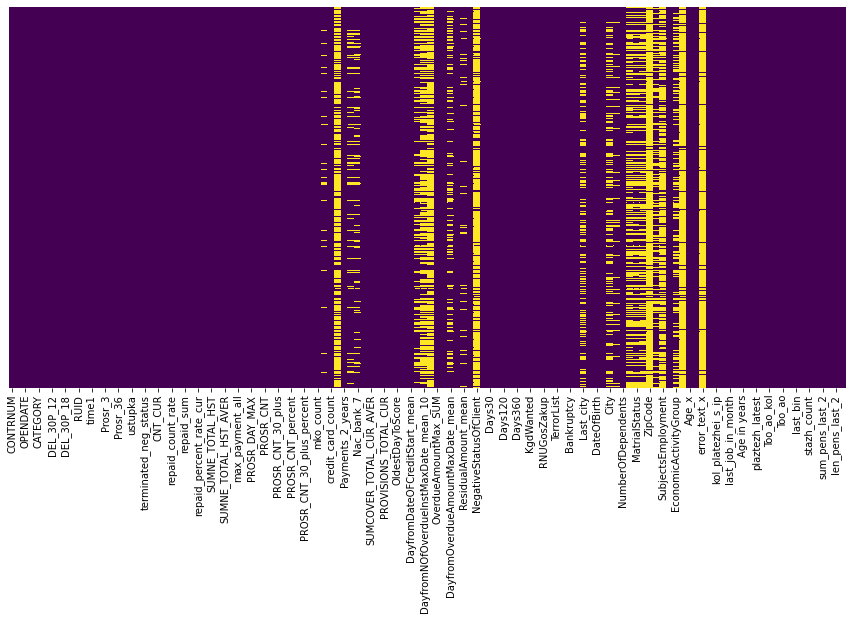

In [9]:
# посмотрим на все значения NAN
fig, ax = plt.subplots(figsize=(15,7))
sns_heatmap = sns.heatmap(df.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

как мы видим в датасете присутствует большое количество пропусков, посмотрим для начала все признаки: опишем их и посмотрим тип данных

In [129]:
feat = pd.read_excel('признаки.xlsx')

In [142]:
feat[feat['источник']=='бюро'].head(20)

,признак,описание,источник
7,RUID,RUID код клиента,бюро
8,request,номер запроса,бюро
9,time1,время запроса,бюро
15,ustupka,уступка/переуступка прав требования по кредит...,бюро
16,current_neg_status,негативный статус хотя бы по одному из действ...,бюро
67,NegativeStatusOfClient,"негативный статус клиента, мы создали признак...",бюро
68,Days7,количество запросов за 7 дней,бюро
69,Days30,количество запросов за 30 дней,бюро
70,Days90,количество запросов за 90 дней,бюро
71,Days120,количество запросов за 120 дней,бюро


In [141]:
feat[feat['источник']=='новый'].head(20)

,признак,описание,источник
10,NegativeStatusOfClient_fin,"признак, имеет ли субъект негативный статус",новый
11,Prosr_3,"просрочка более 10 000тг, более 10 дней за 3 ...",новый
12,Prosr_12,"просрочка более 10 000тг, более 30 дней за 12...",новый
13,Prosr_36,"просрочка более 10 000тг, более 90 дней за 36...",новый
14,Bad_MethodOfPayments,плохие формы расчета (через страховые выплаты...,новый
17,terminated_neg_status,негативный статус хотя бы по одному из закрыт...,новый
18,terminated_neg_status_1,"если имеется проср. > 5 лет, то проверка на з...",новый
19,CNT_CUR,Количество текущих займов,новый
20,CNT_HST,Количество закрытых займов,новый
21,repaid_count_rate,% закрытого количества кредитов от общего кол...,новый


In [131]:
feat['источник'].value_counts()

новый       75
бюро        38
портфель     7
гцвп         3
Name: источник, dtype: int64

итого получается новых сгенерированных признаков 75, также признаки из источников напрямую 42, а так признаки из текущего портфеля по данным субъектам 7

In [11]:
# изменим имена всех столбцов ( все буквы маленькие)
df.columns = df.columns.str.lower()

In [12]:
# удалим сразу лишние признаки, и создадим одну целевую переменную:
df['Default']= df['del_90p_18'].apply(lambda x: 0 if x == 0 else 1)
#df['Default']= df['del_90p_12'].apply(lambda x: 0 if x == 0 else 1)

df = df.drop(columns = ['del_30p_12','del_90p_12','del_30p_18','del_90p_18'])

In [13]:
# удаляем негативный статус, тк имеем признак в числовом формате
# удаляем внутренние идентификаторы и иин/бин субъекта
# удаляем зипкод, тк имеем признак проживания по городам
# удаляем макс срок из ГЦВП, тк имеем такой же признак из  кредитного бюро
# удалим продукт, тк в нем у нас только одно значение
# удалим time1
# также считаю что регион проживания тоже не несет в себе информации, тк мы имеем более точную информацию по городам
df = df.drop(columns = ['negativestatusofclient','ruid','request_x','contrnum','iin_y','iin_x','zipcode',\
                        'max_term_y','product','time1','region','last_bin'])

In [14]:
df.dtypes.value_counts()

float64           82
object            16
int64             12
datetime64[ns]     1
dtype: int64

числовых признаков у нас 94, объектов типа object - 16 и одна колонка с типом дата/время. начнем с обработки полей типа object, больше всего пропусков в значениях ошибках, городе рождения, негативном статусе клиента и характере занятости. рассмотрим все поля подробнее.

In [15]:
df.select_dtypes(include = ['object']).isna().sum().sort_values(ascending=False)

error_text_x             182532
cityofbirth              178479
subjectsemployment       140904
education                 84013
employeessalary           75090
city                      72231
last_city                 71017
matrialstatus             67290
economicactivitygroup     66549
cellularphone             52525
citizenship                  59
dateofbirth                  34
gender                       34
category                      0
age_y                         0
error_text_y                  0
dtype: int64

сначала пройдемся по всем городам (город рождения, город проживания, последние введенные данные по городу) во всех трех признаках имеются пропуски, оставим их без изменения, а также оставим основные города страны в виде циферного значения, а все остальное отнесем к прочим

In [16]:
for i in ['cityofbirth','city','last_city']:
    CityExtract(i)

заполним все пустые ячейки 0, тк вполне возможно что субъект не предоставил ту или иную информацию о себе

In [17]:
obj_columns = df.select_dtypes(include = ['object']).columns
for i in obj_columns:
    df[i].fillna(0, inplace=True)

тк номер мобильного номера нам особо не поможет, просто определим есть номер или нет, создав тем самым бинарный признак

In [18]:
df['cellularphone']= df['cellularphone'].apply(lambda x: 1 if (len(str(x))>=10 and x!='отсутствует') else 0)

In [19]:
# df = df.apply(DateOfBirthCorr, axis=1)
# в целом мы уже имеем признак возраст, думаю дату рождения все-таки можно удалить, 
df = df.drop(columns = ['dateofbirth'])

In [20]:
# все признаки с типом object можно отнести к категориальным
cat_features = df.select_dtypes(include = ['object']).columns.tolist()
cat_features

['category',
 'gender',
 'education',
 'matrialstatus',
 'employeessalary',
 'subjectsemployment',
 'citizenship',
 'economicactivitygroup',
 'error_text_x',
 'age_y',
 'error_text_y']

In [21]:
# посмотрим на список числовых переменных
df.select_dtypes(include = ['int64']).isna().sum().sort_values(ascending=False)

cellularphone           0
kol_platezhei_s_ip      0
kol_platezhei           0
last_job_in_month       0
age in years            0
plaztezh_latest         0
ip_kol                  0
too_ao_kol              0
stazh_count             0
plaztezh_latest_all     0
len_pens_last_2         0
len_pens_between_2_6    0
Default                 0
dtype: int64

In [22]:
#увеличим список категориальных признаков, тк данные колонки не являются числовыми
cat_not_num = ['cellularphone','Default']
cat_features.extend(cat_not_num)

In [23]:
# все признаки с типом int64 можно отнести к числовым, за исключением тех что мы отнесли к категориальным
num_features = df.select_dtypes(include = ['int64']).columns.tolist()
for i in cat_not_num:
    num_features.remove(i)
len(num_features)

11

In [24]:
# теперь посмотрим на признаки с типом float
df.select_dtypes(include = ['float64']).isna().sum().sort_values(ascending=False)

max_prosr_sum                           142126
dayfromnofoverdueinstmaxdate_mean_30    142126
dayfromnofoverdueinstmaxdate_mean_10    108284
dayfromnofoverdueinstmaxdate_mean_0      57219
dayfromoverdueamountmaxdate_mean         54477
                                         ...  
zarplata                                     0
cityofbirth                                  0
city                                         0
last_city                                    0
sum_pens_between_2_6                         0
Length: 85, dtype: int64

In [25]:
# разделим эти признаки на проценты, категориальные и сгенерированные суммы

cat_not_float = ['l150o10','bankruptcy','areears','terrorlist','falsebusi','rnugoszakup',\
 'qamqoralimony','kgdwanted','qamqorlist','negativestatusofclient_fin','last_city','city','cityofbirth']

rates = ['repaid_percent_rate_cur','prosr_cnt_percent','repaid_percent_rate',\
         'repaid_count_rate','prosr_cnt_10_plus_percent','prosr_cnt_30_plus_percent',\
         'prosr_cnt_90_plus_percent', 'amount_cof']

for_log = ['amountloan','repaid_cur_sum','repaid_sum','sumne_total_cur','sumne_total_hst','sumne_total_cur_aver',\
           'sumne_total_hst_aver','max_payment_closed','max_payment_all','cnt_pay','prosr_cnt',\
           'prosr_cnt_10_plus','prosr_cnt_30_plus','prosr_cnt_90_plus','max_prosr_sum','payments_2_years',\
           'nac_bank_8','nac_bank_7','current_payment','sumcover_total_cur_aver','sumcover_total_hst_aver',\
           'provisions_total_cur','provisions_total_hst','residualamount_mean','zarplata', 'zarplata_all',\
           'sum_pens_last_2','sum_pens_between_2_6']

In [26]:
#увеличим список категориальных признаков, тк данные колонки имеют не являются числовыми

cat_features.extend(cat_not_float)

In [27]:
# здесь нужно еще подумать
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i] = df[i].replace([np.inf, -np.inf], 1)

In [28]:
#прологорифмируем все суммы
#for i in for_log:
#    Log(i)

    #тк процентные ставки при переходе на инт станут 0/1, переведем их в процентное соотношение    
for i in rates:
    df[i] = df[i]*100

In [29]:
df.select_dtypes(include = ['float64']).isna().sum().sort_values(ascending=False)

max_prosr_sum                           142126
dayfromnofoverdueinstmaxdate_mean_30    142126
dayfromnofoverdueinstmaxdate_mean_10    108284
dayfromnofoverdueinstmaxdate_mean_0      57219
dayfromoverdueamountmaxdate_mean         54477
                                         ...  
zarplata                                     0
cityofbirth                                  0
city                                         0
last_city                                    0
sum_pens_between_2_6                         0
Length: 85, dtype: int64

In [30]:
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i].fillna(0, inplace=True)

In [31]:
float_features = df.select_dtypes(include = ['float64']).columns.tolist()
for i in cat_not_float:
    float_features.remove(i)
num_features.extend(float_features)

In [32]:
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i] = df[i].astype(int)

In [33]:
df[num_features].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
kol_platezhei_s_ip,194071.0,12.765060,4.898238,0.0,11.0,12.0,13.0,133.0
kol_platezhei,194071.0,12.614790,4.778714,0.0,11.0,12.0,13.0,133.0
last_job_in_month,194071.0,10.752013,3.228088,0.0,10.0,12.0,12.0,34.0
age in years,194071.0,35.960983,11.131384,0.0,28.0,35.0,44.0,62.0
plaztezh_latest,194071.0,1.710822,0.964165,0.0,1.0,2.0,2.0,38.0
...,...,...,...,...,...,...,...,...
ip,194071.0,0.000010,0.003210,0.0,0.0,0.0,0.0,1.0
too_ao,194071.0,0.935008,0.246512,0.0,1.0,1.0,1.0,1.0
zarplata_all,194071.0,194331.219512,178154.982745,0.0,96132.5,139120.0,216531.5,3862933.0
sum_pens_last_2,194071.0,49162.240829,49499.000136,0.0,22466.5,34550.0,56191.0,2665853.0


In [34]:
# дата начала кредитного соглашения у нас и так имеется при генерации фичей, этот признак можно бдует удалить
df = df.drop(columns = df.select_dtypes(include = ['datetime64[ns]']).columns)

In [35]:
df.dtypes.value_counts()

int32     85
int64     13
object    11
dtype: int64

с предобработкой закончили, теперь посмотрим на признаки более внимательно и возможно удалим лишнее

### разведывательный анализ данных

начнем с категориальных признаков, среди них имеется целевая переменна исключим ее

In [36]:
#посмотрим на дефолты в разрезе категорий 
def_categ = df.groupby(['category', 'Default'], dropna=False)['category'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'Распределение дефолта в разрезе категорий')

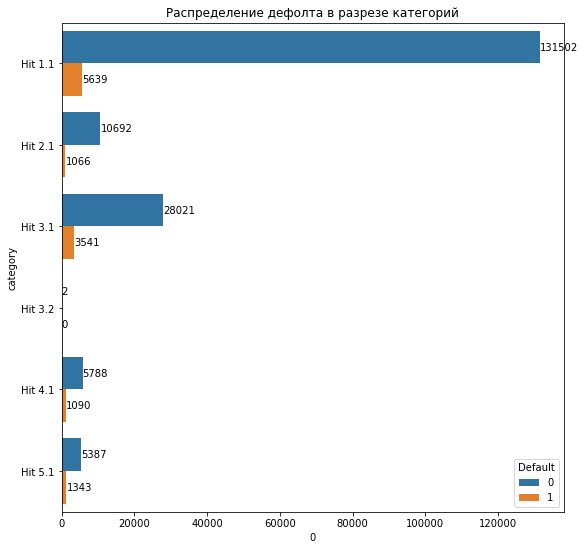

In [37]:
plt.rcParams['figure.figsize']=9,9
ax = sns.barplot(x=0, y='category', hue='Default', data=def_categ)
ShowValuesOnBars(ax, 'h', 8)
plt.title('Распределение дефолта в разрезе категорий')
plt.show()

наблюдаем градиентное увеличение количества дефолтных клиентов от хит1 к хит5

In [38]:
#посмотрим на дефолты в разрезе категорий 
def_salary = df.groupby(['employeessalary', 'Default'], dropna=False)['employeessalary'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'Распределение дефолта в разрезе заработной платы')

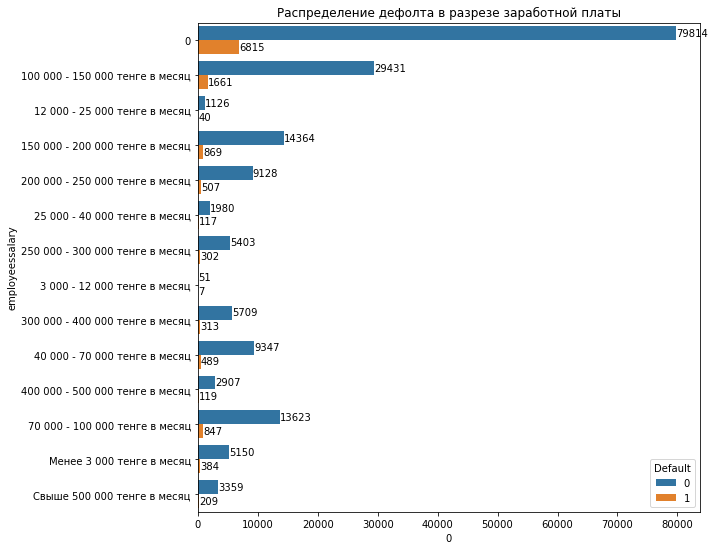

In [39]:
plt.rcParams['figure.figsize']=9,9
ax = sns.barplot(x=0, y='employeessalary', hue='Default', data=def_salary)
ShowValuesOnBars(ax, 'h', 8)
plt.title('Распределение дефолта в разрезе заработной платы')
plt.show()

большое количество дефолтов у клиентов не имеющих кредитной истории, в целом распределение равномерное

In [133]:
import scikit_posthocs as sp
for i in num_features[:20]:
    print('Переменная: '+i+', количество выбросов:', len(sp.outliers_iqr(df[i], ret = 'outliers')))

Переменная: kol_platezhei_s_ip, количество выбросов: 36826
Переменная: kol_platezhei, количество выбросов: 36169
Переменная: last_job_in_month, количество выбросов: 29552
Переменная: age in years, количество выбросов: 3454
Переменная: plaztezh_latest, количество выбросов: 8248
Переменная: ip_kol, количество выбросов: 8367
Переменная: too_ao_kol, количество выбросов: 36231
Переменная: stazh_count, количество выбросов: 12164
Переменная: plaztezh_latest_all, количество выбросов: 16275
Переменная: len_pens_last_2, количество выбросов: 16296
Переменная: len_pens_between_2_6, количество выбросов: 37230
Переменная: amountloan, количество выбросов: 10172
Переменная: prosr_3, количество выбросов: 229
Переменная: prosr_12, количество выбросов: 298
Переменная: prosr_36, количество выбросов: 238
Переменная: bad_methodofpayments, количество выбросов: 2900
Переменная: ustupka, количество выбросов: 19087
Переменная: current_neg_status, количество выбросов: 708
Переменная: terminated_neg_status, колич

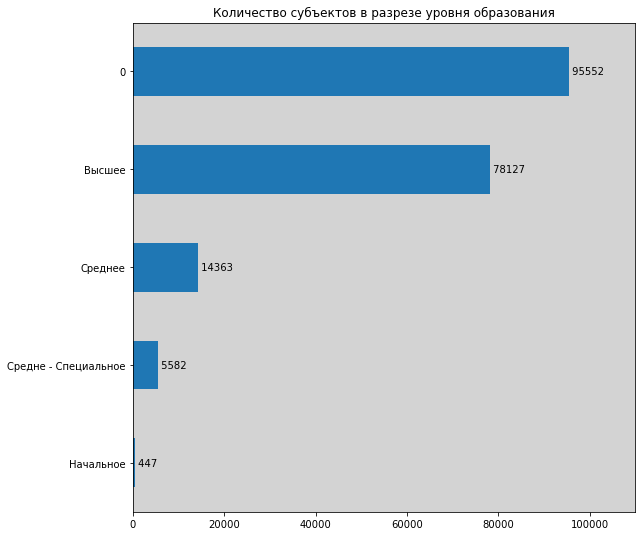

In [41]:
VizCounterBar(df,'education','Количество субъектов в разрезе уровня образования')

нужно провести более тщательный анализ признаков и подумать над выбросами, хотя выбросы критичны для лог.регрессии

### корреляционный анализ переменных

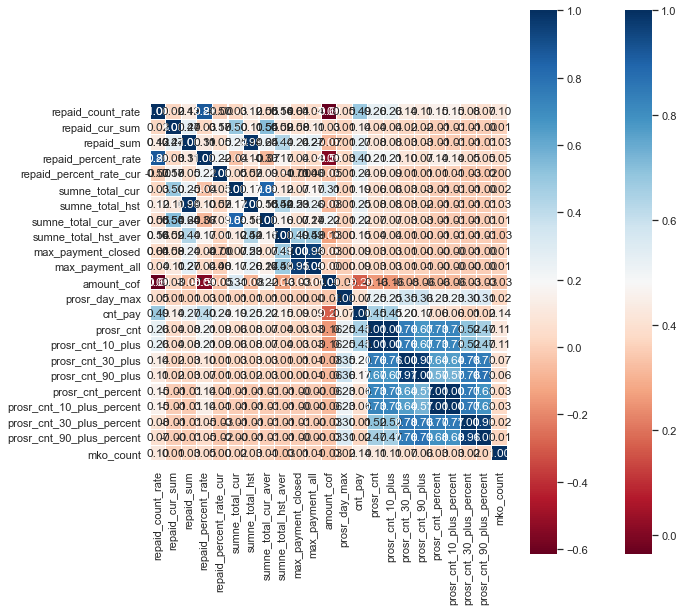

In [42]:
# теперь посмотрим на корреляцию числовых признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(10,10))
sns.heatmap(df[num_features[0:12]].corr(), square=True, annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu");
sns.heatmap(df[num_features[22:45]].corr(), square=True, annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu");

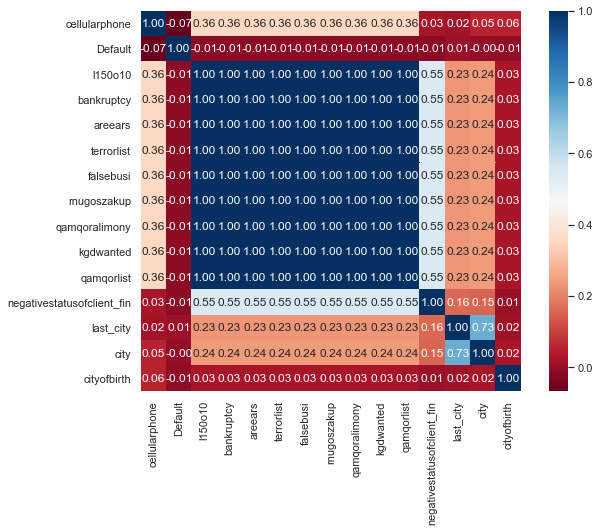

In [43]:
# теперь посмотрим на корреляцию категориальных признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(10,7))
sns.heatmap(df[cat_features].corr(), square=True, annot=True, fmt=".2f", cmap="RdBu");

все корреляции нужно подчистить и снести к чертям все лишние, типа инфы с гос.структур

In [44]:
# сильно коррелируют города, уберем один из признаков
# информация с гос.источников не несет в себе 
#
df = df.drop(columns = ['city','economicactivitygroup'])

In [45]:
cat_features.remove('city')
cat_features.remove('economicactivitygroup')

### подготовка данных к машинному обучению

In [46]:
df2 = df.copy()

In [48]:
# для категориальных признаков мы будем использовать OneHotEncoder
for column in ['category','gender','education','matrialstatus','employeessalary','subjectsemployment',\
               'citizenship', 'error_text_x','error_text_y']:
    dummies = pd.get_dummies(df2[column])
    df2[dummies.columns] = dummies

In [49]:
df2=df2.drop(columns=['category','gender','education','matrialstatus','employeessalary','subjectsemployment',\
               'citizenship', 'error_text_x','error_text_y',0])

In [50]:
# cтандартизация
#df[num_features] = StandardScaler().fit_transform(df[num_features].values)
#df[num_features] = MinMaxScaler().fit_transform(df[num_features].values)

<AxesSubplot:>

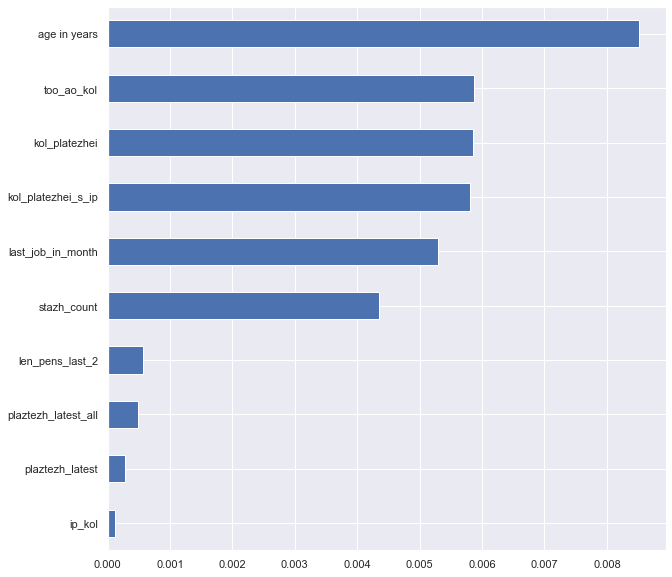

In [162]:
# значимость числовых переменных
all_cols = list(df2.columns)
all_num_cols = num_features
target_col = ['Default']
all_cat = [x for x in all_cols if x not in (all_num_cols+target_col)]

temp_df = df2
imp_cat = pd.Series(mutual_info_classif(temp_df[num_features], temp_df['Default'], discrete_features =True), index = num_features)[:10]
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')


<AxesSubplot:>

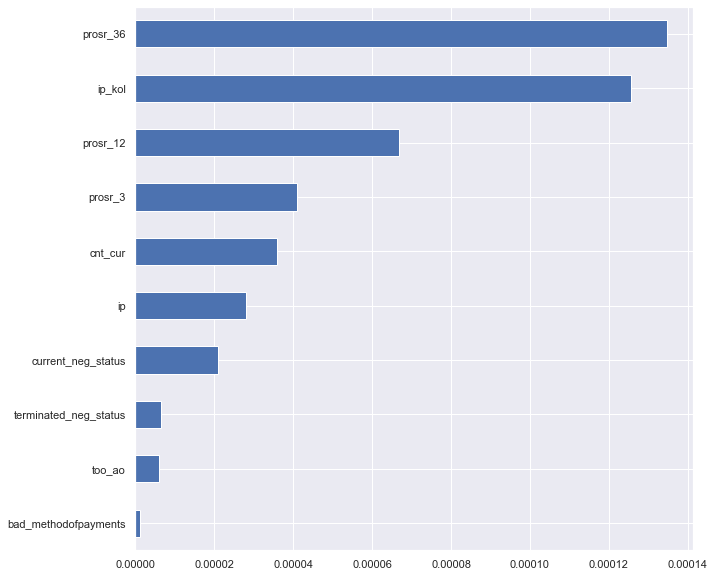

In [135]:
top_10=imp_cat.sort_values(ascending=True)[:10]
top_10.plot(kind = 'barh')

In [53]:
X = df.drop(['Default'], axis=1)
y = df.Default.values
X.shape

(194071, 106)

In [54]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=47)

In [55]:
X_tr.shape, X_val.shape

((155256, 106), (38815, 106))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.3, shuffle=True, random_state=47)

In [57]:
X_train.shape,X_test.shape

((108679, 106), (46577, 106))

### обучаем разные модели и смотрим на результат

In [58]:
df2=df2.drop(columns=['age_y'])

In [59]:
X_2= df2.drop(['Default'], axis=1)
y_2 = df2.Default.values
X_2.shape

(194071, 140)

In [60]:
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_2, y_2, test_size=0.2, shuffle=True, random_state=47)

In [61]:
mod_time=[]

In [62]:
# KNeighborsClassifier:
start = time.monotonic()
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
alg_ngbh.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_ngbh, X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (k-neighbors): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

KNeighborsClassifier(n_neighbors=3)

roc_auc (k-neighbors): 0.5678452680455128/0.010596466250530623
Program time: 46.438 seconds.


In [63]:
%%time
# LogisticRegression:
start = time.monotonic()
alg_log = LogisticRegression(random_state=47, max_iter=200)
alg_log.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_log, X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (logistic regression): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

roc_auc (logistic regression): 0.6247736536470825/0.0076346759326023856
Program time: 13.016 seconds.
Wall time: 13 s


In [64]:
features=X_val2.columns
importance = alg_log.coef_[0]
#feat_imp=pd.concat(features,importance)
importance.dtype

dtype('float64')

In [156]:
pd.DataFrame(index=features, data=importance).sort_values(0,ascending=False)[:3]

,0
provisions_total_cur,1.279788e-06
provisions_total_hst,8.034617e-07
residualamount_mean,4.508728e-07


In [66]:
# RandomForestClassifier:
start = time.monotonic()
alg_frst = RandomForestClassifier(random_state=47, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
alg_frst.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_frst,X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (random forest): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=47)

roc_auc (random forest): 0.793042741162439/0.00433798806328483
Program time: 312.047 seconds.


In [67]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(alg_frst.feature_importances_, index=X_tr2.columns)
feat_importances.sort_values(ascending=False)[:5]

amountloan                       0.030366
dayfromdateofcreditstart_mean    0.029806
oldestdaytoscore                 0.026560
max_term_x                       0.026372
sum_pens_last_2                  0.025023
dtype: float64

In [68]:
# GradientBoostingClassifier:
start = time.monotonic()
alg_gb = GradientBoostingClassifier(random_state=47)
alg_gb.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_gb, X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (gradient boosting): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

GradientBoostingClassifier(random_state=47)

roc_auc (gradient boosting): 0.8068024091294583/0.002136080662905537
Program time: 163.000 seconds.


In [69]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(alg_gb.feature_importances_, index=X_tr2.columns)
feat_importances.sort_values(ascending=False)[:5]

Hit 1.1                          0.128324
dayfromdateofcreditstart_mean    0.094500
days120                          0.068470
prosr_cnt_percent                0.062179
days180                          0.060348
dtype: float64

In [70]:
cat_feat=X.columns
cat_feat

Index(['amountloan', 'category', 'negativestatusofclient_fin', 'prosr_3',
       'prosr_12', 'prosr_36', 'bad_methodofpayments', 'ustupka',
       'current_neg_status', 'terminated_neg_status',
       ...
       'ip', 'too_ao', 'zarplata_all', 'error_text_y', 'stazh_count',
       'plaztezh_latest_all', 'sum_pens_last_2', 'sum_pens_between_2_6',
       'len_pens_last_2', 'len_pens_between_2_6'],
      dtype='object', length=106)

In [71]:
start = time.monotonic()
catclass = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47,verbose=False,l2_leaf_reg=1)

catclass.fit(X_train,y_train,eval_set=(X_test,y_test),cat_features=cat_feat, use_best_model=True,verbose=False)
pred = catclass.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)
tpr,fpr,_=roc_curve(y_score=pred,y_true=y_test)

0.8090098427773792
Program time: 2059.672 seconds.


In [72]:
pred_val = catclass.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, pred_val))
tpr,fpr,_=roc_curve(y_score=pred_val,y_true=y_val)

0.817740745518389


In [73]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(catclass.feature_importances_, index=X_test.columns)
feat_importances.sort_values(ascending=False)[:5]

amountloan             7.145133
category               6.912408
gender                 5.136273
repaid_percent_rate    4.631617
cnt_hst                4.114300
dtype: float64

<AxesSubplot:>

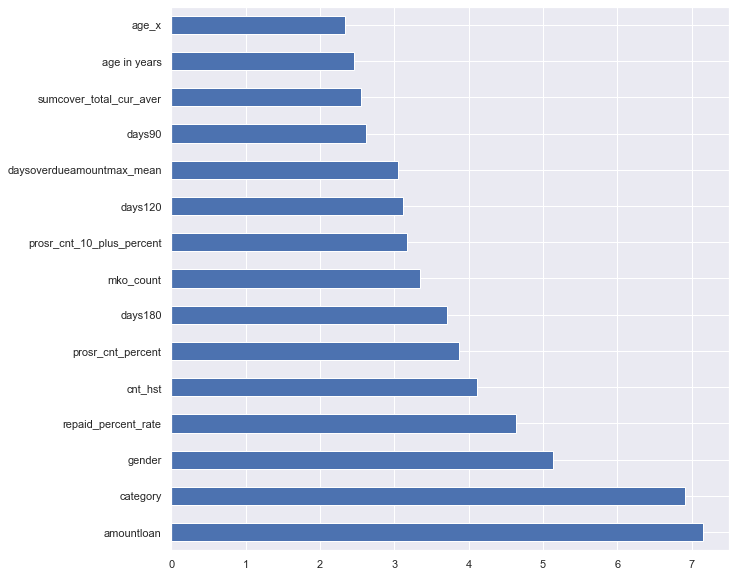

In [74]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(catclass.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[43503    54]
 [ 2949    71]]


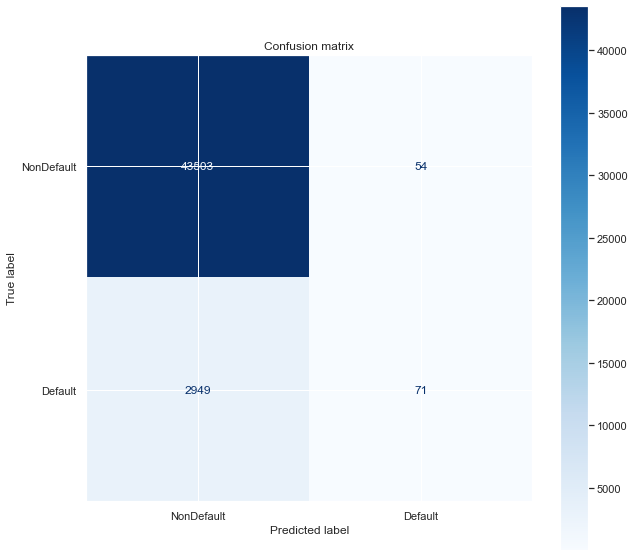

In [75]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(catclass, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

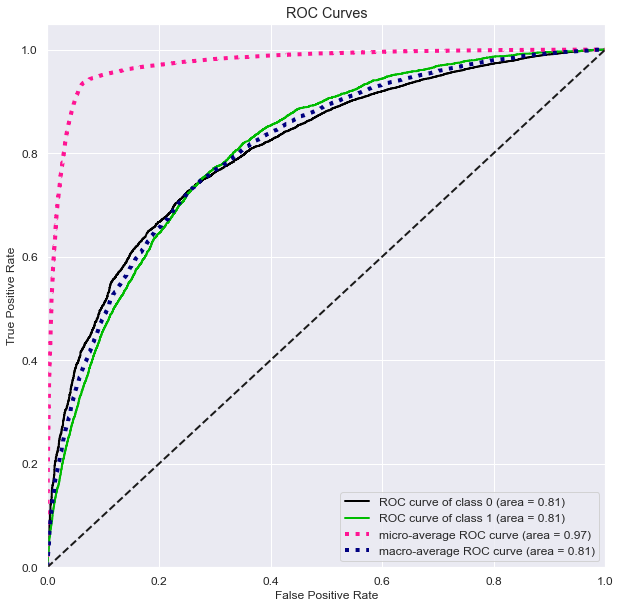

In [76]:
y_probas =catclass.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

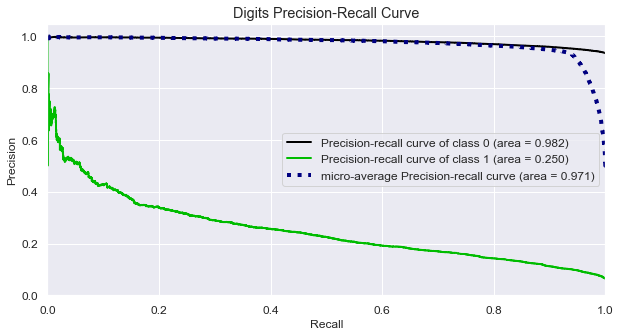

In [77]:
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

модель которую мы получили очень плохая. Мы почти не угадали ни одного дефолтного клиента, таким образом все клиенты попали в ошибку второго рода, а это очень плохо для банка. Несмотря на это площадь под ROC кривой оказалась не такой уж плохой. Дело в том что эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных, поэтому добавили Precision-Recall кривую.

In [78]:
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=47)
#X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)

In [79]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=47)
X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)

добавила андерсемплинг, таким образом искуственно уменьшим недефолтный класс, чтобы ярче увидеть признаки дефолтного класса в датасете и обучимся катбусту еще раз

In [80]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle=True, random_state=47)

In [81]:
%%time
catclass2 = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47,\
                               iterations=160, depth=6,learning_rate=0.26,random_strength=76,\
                               bagging_temperature=42,od_type='IncToDec',od_wait=39)

Wall time: 998 µs


In [82]:
%%time
catclass2.fit(X_resampled, y_resampled,eval_set=(X_val,y_val),cat_features=cat_feat,use_best_model=True,verbose=False)

Wall time: 9.31 s


In [83]:
%%time
pred2 = catclass2.predict_proba(X_test_r)[:,1]
print(roc_auc_score(y_test_r, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_test_r)

0.9564278513439146
Wall time: 108 ms


In [163]:
pred2 = catclass2.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_test)

0.94975103104568


In [84]:
pred2 = catclass2.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_val)

0.8092706895302687


тк для банковского сектора важен показатель Джини, добавила его в расчеты

In [85]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1.0 / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1.0 / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [86]:
Gini(y_val, pred2)

0.6185403181627989

Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[25839 10429]
 [  628  1919]]


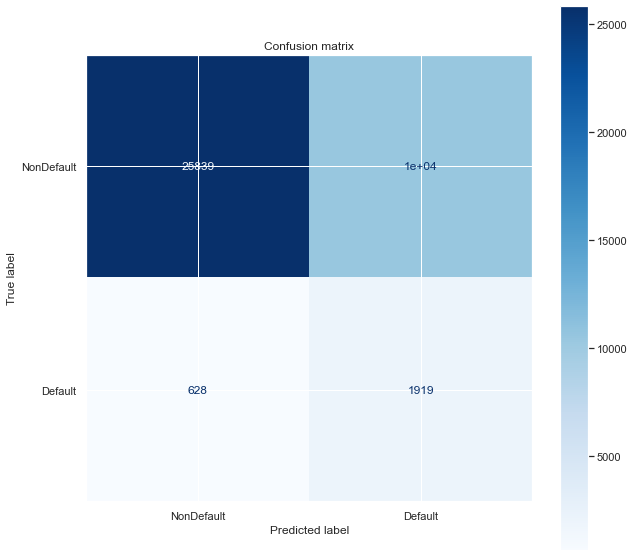

In [87]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(catclass2, X_val, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

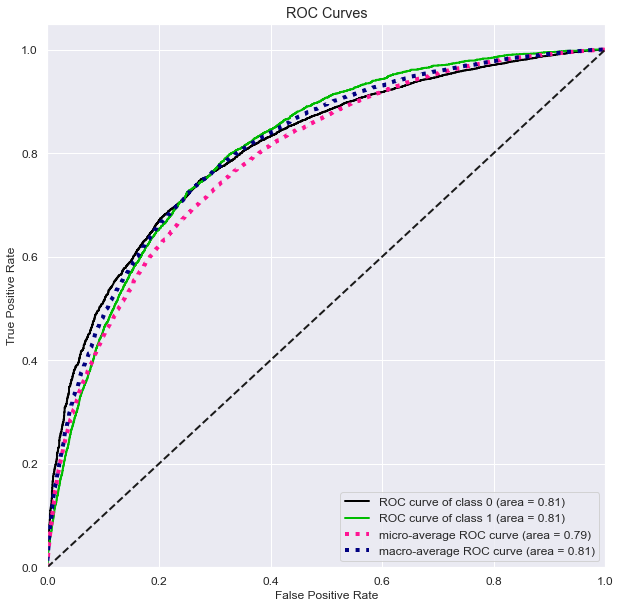

In [88]:
y_probas =catclass2.predict_proba(X_val)

skplt.metrics.plot_roc_curve(y_val, y_probas)
plt.show()

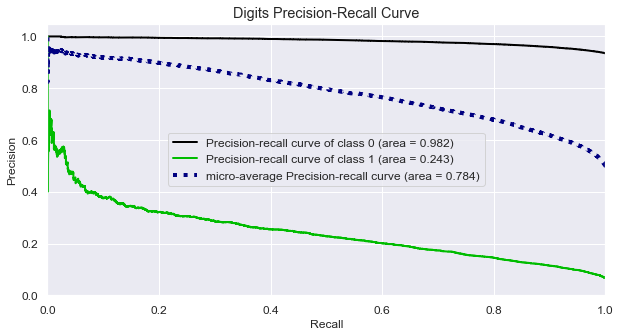

In [89]:
skplt.metrics.plot_precision_recall_curve(y_val, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

картинка стала намного лучше, плохо видно теперь недефолтный класс, попробуем подобрать гиперпараметры с помощью оптуны

In [90]:
from catboost import Pool
import sklearn.metrics
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_resampled, y_resampled, test_size=0.8, random_state=47)
    train_pool = Pool(train_x, train_y, cat_features=cat_feat)
    test_pool = Pool(test_x, test_y, cat_features=cat_feat)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 980),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    ROCAUC = sklearn.metrics.roc_auc_score(test_y, preds)
    return ROCAUC

In [91]:
## подбор гиперпараметров
#if __name__ == '__main__':
#    study = optuna.create_study()
#    study.optimize(objective, n_trials=3)
#    #print(study.best_trial)
#study.best_params

In [ ]:
#optuna.visualization.plot_slice(study)

In [93]:
%%time
catclass3 = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47,\
                               iterations=609, depth=10,learning_rate=0.012,random_strength=99,\
                               bagging_temperature=8.05,od_type='IncToDec',od_wait=39)

Wall time: 0 ns


In [94]:
%%time
catclass3.fit(X_resampled, y_resampled,eval_set=(X_val,y_val),cat_features=cat_feat,use_best_model=True,verbose=False)

Wall time: 24min 22s


In [95]:
%%time
pred3 = catclass3.predict_proba(X_test_r)[:,1]
print(roc_auc_score(y_test_r, pred3))
tpr,fpr,_=roc_curve(y_score=pred3,y_true=y_test_r)

0.8660910569660016
Wall time: 163 ms


In [96]:
pred3 = catclass3.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, pred3))
tpr,fpr,_=roc_curve(y_score=pred3,y_true=y_val)

0.7921635727640963


In [97]:
Gini(y_val, pred3)

0.5843310427035591

optuna не помогла, а даже ухудшила картинку

Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[25967 10301]
 [  712  1835]]


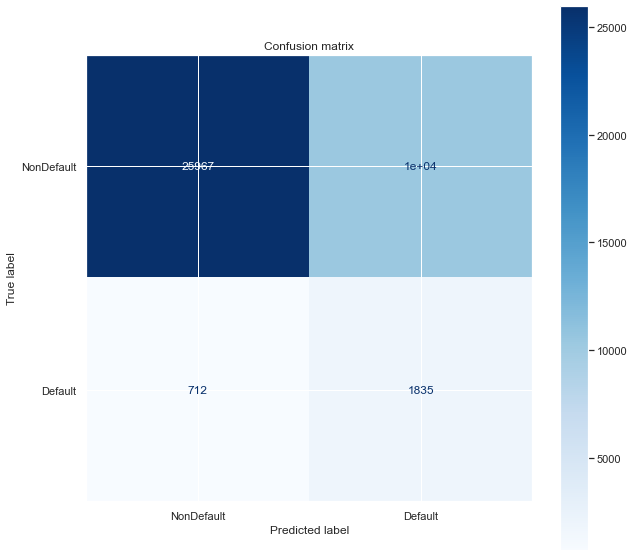

In [98]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(catclass3, X_val, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

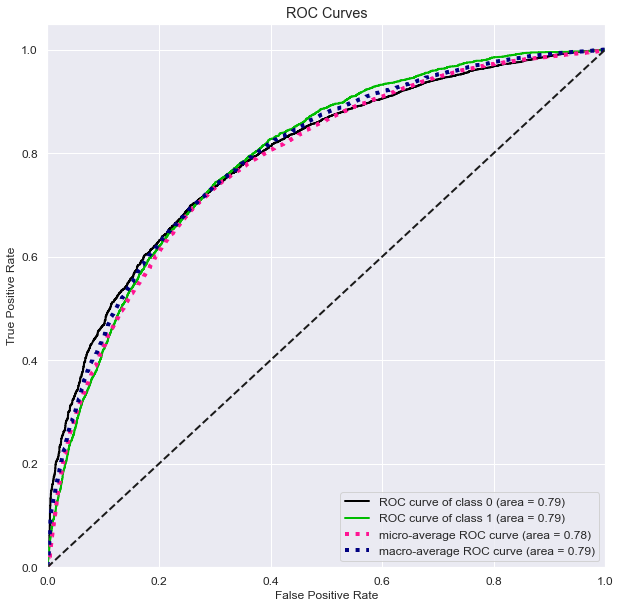

In [99]:
y_probas =catclass3.predict_proba(X_val)

skplt.metrics.plot_roc_curve(y_val, y_probas)
plt.show()

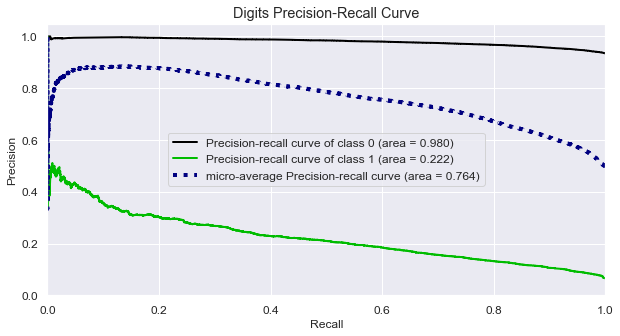

In [100]:
skplt.metrics.plot_precision_recall_curve(y_val, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

In [101]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations=780,
                          learning_rate=0.2,
                          depth=6,
                          random_state=47,
                          random_strength=76,
                          bagging_temperature=42,
                          eval_metric='AUC',
                          od_type='IncToDec',
                          od_wait=39,
                          od_pval=0.002)
    
    model.fit(X_train, y_train,
              cat_features=cat_feat,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)


также попылась обучить модель катбуст регрессию, которая обучалась 3 фолдами через кросс-валидацию, возможно будет полезной

In [102]:
score_ls = []
N_FOLDS = 3
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=47).split(X_resampled, y_resampled))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    X_train, y_train, X_test, y_test = X_resampled.iloc[train_idx], y_resampled[train_idx], X_resampled.iloc[test_idx],y_resampled[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = roc_auc_score(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test ROC AUC: {roc_auc_score(y_test, test_predict):0.3f}")
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')
#''', 

  0%|          | 0/3 [00:00<?, ?it/s]

1 Fold Test ROC AUC: 0.803


 33%|███▎      | 1/3 [03:18<06:37, 198.95s/it]

2 Fold Test ROC AUC: 0.800


 67%|██████▋   | 2/3 [08:22<04:20, 260.37s/it]

3 Fold Test ROC AUC: 0.798


100%|██████████| 3/3 [12:55<00:00, 258.43s/it]


Mean Score: 0.801
Std Score: 0.0020
Max Score: 0.803
Min Score: 0.798


<AxesSubplot:>

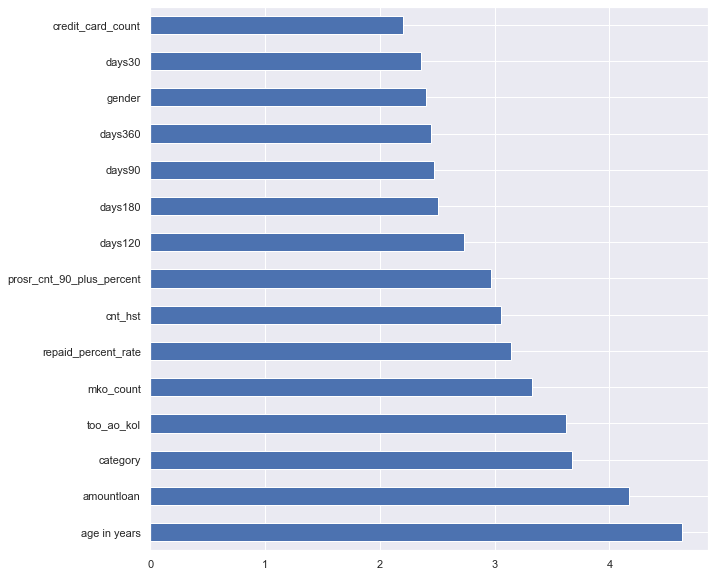

In [103]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

добавила пробу в датасет и попробую посчитать возможный доход банка при запуске данной модели на бой: недополученную прибыль Банка по ложно-отрицательным + съеэкономленные банковские средства по истинно-отрицательным признакам

In [104]:
y_probas_all =catclass2.predict_proba(X)

In [105]:
df['proba'] = y_probas_all[:,1]

In [107]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    facet.set_xticklabels(rotation=90)

In [108]:
df['bins']=df['proba']*10
df['bins']=df['bins'].astype('int')

In [109]:
aggregation_functions = { 'amountloan':'sum', 'amountloan':'count'}
df.groupby(by=['bins', 'Default'], as_index = False).aggregate(aggregation_functions)  

,bins,Default,amountloan
0,0,0,25075
1,0,1,33
2,1,0,34993
3,1,1,151
4,2,0,27311
5,2,1,356
6,3,0,24521
7,3,1,549
8,4,0,19318
9,4,1,782


In [110]:
#возьмем только последние два класса
list1 = []
for i in range(8,10):
    skolko_sekonomila = df[(df['bins']>=i)&(df['Default']==1)]['amountloan'].sum()
    skolko_bank_ne_zarabotal = df[(df['bins']>=i)&(df['Default']==0)]['amountloan'].sum() * 0.06
    moya_polza = skolko_sekonomila - skolko_bank_ne_zarabotal
    dict1 ={'bin': i, 'skolko_sekonomila':skolko_sekonomila, 'skolko_bank_ne_zarabotal':skolko_bank_ne_zarabotal,\
            'moya_polza':moya_polza}
    list1.append(dict1)
a1 = pd.DataFrame(list1, columns=['bin', 'skolko_sekonomila', 'skolko_bank_ne_zarabotal', 'moya_polza'])
a1

,bin,skolko_sekonomila,skolko_bank_ne_zarabotal,moya_polza
0,8,10047307226,7.361660e+08,9.311141e+09
1,9,5277849879,1.590649e+08,5.118785e+09


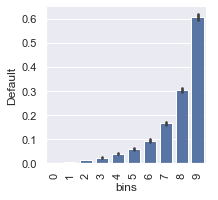

In [111]:
plot_categories(df , cat = 'bins' , target = 'Default', color='red')

In [119]:
##попробуем также модель LightAutoML
N_THREADS = 24 # threads cnt for LightAutoML models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 47 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3600 # Time in seconds for automl run
TARGET_NAME = 'Default' # Target column name

In [120]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

def auc_metric(y_true, y_pred, **kwargs):
    return roc_auc_score(y_true, (y_pred > 0.12).astype(int), **kwargs)

task = Task('binary', metric = auc_metric)
roles = {'target': TARGET_NAME}

In [121]:
for i in df2.columns:
    df2[i].fillna(0, inplace=True)

In [122]:
tr_data, ts_data = train_test_split(df2, test_size=TEST_SIZE, \
                                    stratify=df2[TARGET_NAME],\
                                    random_state=RANDOM_STATE)

In [123]:
%%time 
start = time.monotonic()
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       verbose = 0
                      )
oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

oof_pred:
array([[0.11982033],
       [0.2916918 ],
       [0.00691605],
       ...,
       [0.01115047],
       [0.02665093],
       [0.0567425 ]], dtype=float32)
Shape = (155256, 1)
Program time: 1271.266 seconds.
Wall time: 21min 11s


Wall time: 154 ms


<AxesSubplot:xlabel='Feature'>

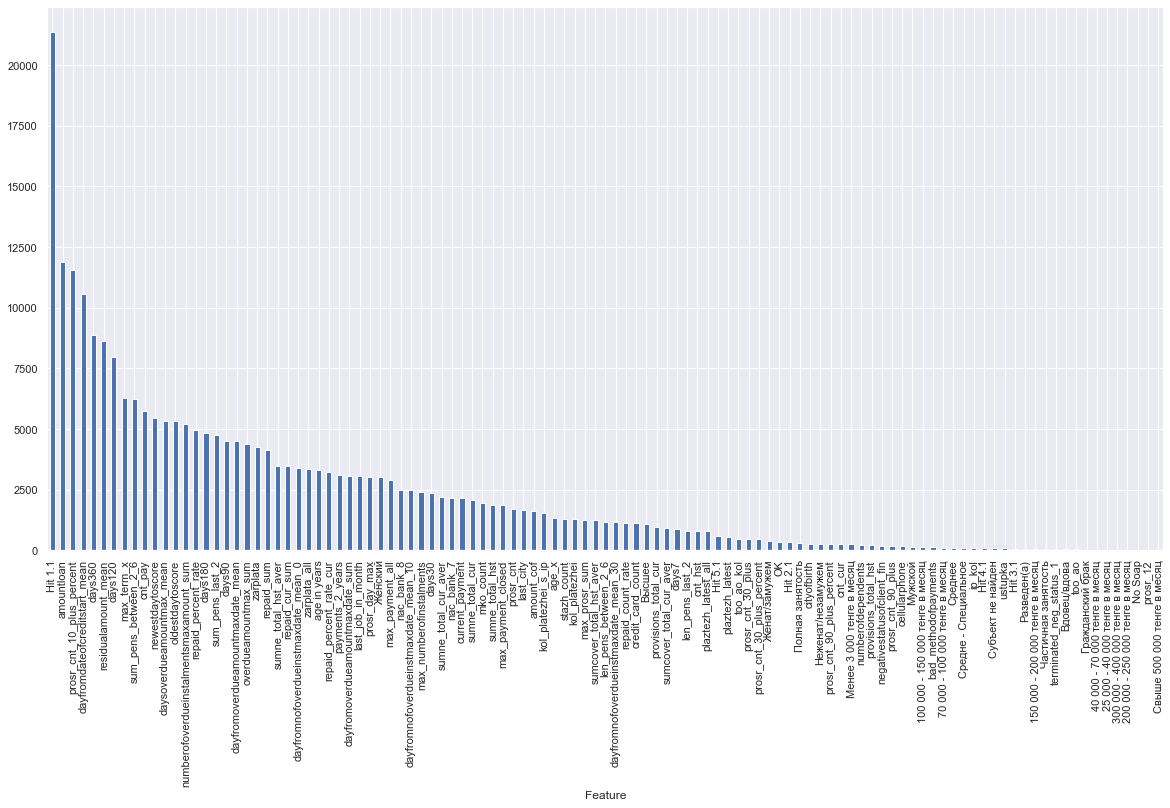

In [125]:
%%time

## Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [127]:
def roc_m(y_true, y_pred, bound = 0.5):
    return roc_auc_score(y_true, y_pred)
best_score = -1
best_w = None
for w in np.arange(0, 1.01, 0.01):
    cur_score = roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])
    if cur_score > best_score:
        best_score = cur_score
        best_w = w
        print(best_w, best_score)
        
print('='*10)
print(best_w, best_score)

0.0 0.8250227972379391
0.0 0.8250227972379391


In [128]:
%%time

test_pred = automl.predict(ts_data)
print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('TEST score: {}'.format(roc_auc_score(ts_data[TARGET_NAME].values, test_pred.data[:, 0])))

Prediction for test data:
array([[0.10271822],
       [0.08850087],
       [0.06428325],
       ...,
       [0.02402936],
       [0.04170232],
       [0.01341691]], dtype=float32)
Shape = (38815, 1)
Check scores...
OOF score: 0.8250227972379391
TEST score: 0.8336912325899098
Wall time: 3.27 s


In [136]:
mod_time

[46.43799999999828,
 13.015999999999622,
 312.04699999999866,
 163.0,
 2059.6719999999987,
 1271.2660000000033]